In [50]:
"""
File that runs the actual reconstruction optimizer forward pass. 
It should compute 3 loss functions: contour chamfer loss, tip distance 
loss, and motion model loss. In its forward pass, it will call upon 
the construction_bezier and motion_catheter scripts to build its 
catheters. It will be optimizing the parameter para_init. 
"""
import sys
sys.path.append('..')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')

import torch
import torch.nn as nn
import cv2
# from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from construction_bezier import ConstructionBezier
from loss_define import (
    ContourChamferLoss, 
    TipDistanceLoss, 
    ImageContourChamferLoss, 
    GenerateRefData
)

from catheter_motion import CatheterMotion


class ReconstructionOptimizer(nn.Module): 

    def __init__(self, p_start, para_init, image_ref, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list): 
        '''
        This function initializes the catheter optimization model.

        Args:
            p_start (tensor): starting point of the catheter
            image_ref (numpy array): reference image to compare to
            gpu_or_cpu (str): either 'cuda' or 'cpu'
        '''
        super().__init__()

        self.build_bezier = ConstructionBezier(radius=0.0015)
        self.build_bezier.to(gpu_or_cpu)
        self.build_bezier.loadRawImage(img_save_path)

        self.contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
        self.contour_chamfer_loss.to(gpu_or_cpu)
        self.tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
        self.tip_distance_loss.to(gpu_or_cpu)
        self.image_contour_chamfer_loss = ImageContourChamferLoss(device=gpu_or_cpu)
        self.image_contour_chamfer_loss.to(gpu_or_cpu)
        
        # Declare self.tip_euclidean_distance_loss as a variable that'll hold a single numpy scalar value
        self.tip_euclidean_distance_loss = None
        self.tip_loss = None

        self.p_start = p_start.to(gpu_or_cpu).detach()
        self.para_init = nn.Parameter(torch.from_numpy(para_init).to(gpu_or_cpu),
                                      requires_grad=True)
        
        
        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Generate reference data, so you don't need to generate it in every forward pass
        self.generate_ref_data = GenerateRefData(self.image_ref)
        ref_catheter_contour = self.generate_ref_data.get_raw_contour()
        # self.register_buffer('ref_catheter_contour', ref_catheter_contour)
        self.ref_catheter_contour = ref_catheter_contour
        ref_catheter_centerline = self.generate_ref_data.get_raw_centerline()
        # self.register_buffer('ref_catheter_centerline', ref_catheter_centerline)
        self.ref_catheter_centerline = ref_catheter_centerline
        
        # self.register_buffer('delta_u_list', delta_u_list)
        self.delta_u_list = delta_u_list
        # self.register_buffer('past_frames_list', past_frames_list)
        # self.register_buffer('image_save_path_list', image_save_path_list)
        self.image_save_path_list = image_save_path_list
        
        # Generate reference data for past frames
        contour_list = []
        centerline_list = []
        for image in past_frames_list:
            image = torch.from_numpy(image.astype(np.float32))
            generate_ref_data = GenerateRefData(image)
            ref_catheter_contour = generate_ref_data.get_raw_contour()
            ref_catheter_centerline = generate_ref_data.get_raw_centerline()
            contour_list.append(ref_catheter_contour)
            centerline_list.append(ref_catheter_centerline)
        # self.register_buffer('contour_list', torch.stack(contour_list))
        # self.register_buffer('centerline_list', torch.stack(centerline_list))
        self.contour_list = contour_list
        self.centerline_list = centerline_list
        
        self.gpu_or_cpu = gpu_or_cpu

    def forward(self, save_img_path): 
        '''
        Function to run forward pass of the catheter optimization model.
        Creates catheter model, gets projection onto 2d image, and calculates loss.

        Args:
            save_img_path (str): path to save the projection image to
        '''

        # print('hello')
        
        # Generate the Bezier curve cylinder mesh points
        self.build_bezier.getBezierCurveCylinder(self.p_start, self.para_init)

        # Get 2d projected Bezier Cylinder mesh points
        self.build_bezier.getCylinderMeshProjImg()

        # Get 2d projected Bezier centerline (position) points
        self.build_bezier.getBezierProjImg()

        loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.ref_catheter_contour.to(self.gpu_or_cpu))

        loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.ref_catheter_centerline.to(self.gpu_or_cpu))
        
        p0 = self.p_start.detach().cpu().numpy()
        para_init = self.para_init.detach().cpu().numpy()
        catheterMotion = CatheterMotion(p0, r=0.0015)
        predicted_paras = catheterMotion.past_frames_prediction(self.delta_u_list, para_init)
        motion_model_loss = torch.tensor(0.0).to(self.gpu_or_cpu)
        for i in range(len(predicted_paras)):
            construction_bezier = ConstructionBezier()
            construction_bezier.to(self.gpu_or_cpu)
            construction_bezier.loadRawImage(self.image_save_path_list[i])
            construction_bezier.getBezierCurveCylinder(self.p_start, torch.from_numpy(predicted_paras[i]).to(self.gpu_or_cpu))
            construction_bezier.getCylinderMeshProjImg()
            construction_bezier.getBezierProjImg()
            # build_bezier.draw2DCylinderImage(self.past_frames_list[i], save_img_path_list[i])
            
            loss_contour_m = self.contour_chamfer_loss(construction_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.contour_list[i].to(self.gpu_or_cpu))
             
            # motion_model_loss += loss_contour_m.to(self.gpu_or_cpu)
            
            loss_tip_distance_m, self.tip_loss = self.tip_distance_loss(construction_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.centerline_list[i].to(self.gpu_or_cpu)) 
            weight_m = torch.tensor([1.0e-4, 1.0]).to(self.gpu_or_cpu)
            loss_m = loss_contour_m.to(self.gpu_or_cpu) * weight_m[0] + loss_tip_distance_m.to(self.gpu_or_cpu) * weight_m[1]
            motion_model_loss += loss_m.to(self.gpu_or_cpu)
            
        
        weight = torch.tensor([1.0e-4, 1.0, 1.0e-5]).to(self.gpu_or_cpu)
        # weight = torch.tensor([1.0e-5, 1.0, 1.0e-6]).to(self.gpu_or_cpu)
        # loss = loss_contour.to(self.gpu_or_cpu) * weight[0] + loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        loss = loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        
        # self.build_bezier.draw2DCylinderImage(self.image_ref, save_img_path)


        # print("-----------------------------------------------------------------")
        # print("loss_contour: ", loss_contour.item())
        # # print("loss_tip: ", loss_tip)
        # # print("loss_boundary: ", loss_boundary)
        # print("loss_tip_distance: ", loss_tip_distance.item())
        # # print("loss_boundary_point_distance_loss: ", loss_boundary_point_distance_loss)
        # print("motion_model_loss: ", motion_model_loss.item())
        # # print("loss: ", loss)
        # print("-----------------------------------------------------------------")


        # TODO: Plot the loss

        return loss
    





In [51]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

In [52]:
def excecute(para_init, i):
    ###========================================================
    ### 1) SET TO GPU OR CPU COMPUTING
    ###========================================================
    if torch.cuda.is_available():
        gpu_or_cpu = torch.device("cuda:0") 
        torch.cuda.set_device(gpu_or_cpu)
    else:
        gpu_or_cpu = torch.device("cpu")

    ###========================================================
    ### 2) VARIABLES FOR BEZIER CURVE CONSTRUCTION
    ###========================================================
    # para_init = torch.tensor([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.0])


    # Z axis + 0.1
    # para_init = torch.tensor([0.02, 0.002, 0.1, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.1000])
        
    

    # p_start and para_init used for SRC presentation
    # ground truth: [ 0.02007997  0.00160014  0.1026283   0.02973628 -0.04668138  0.19240253]
    p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip
    # para_init = np.array([0.0365, 0.0036,  0.1202,  0.0056, -0.0166, 0.1645],
    #                  dtype=np.float32) # 0, converge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0206, -0.0306, 0.1845],
    #                  dtype=np.float32) # 1, converge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0306, 0.1815],
    #                  dtype=np.float32) # 2, converge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0266, 0.2115],
    #                  dtype=np.float32) # 3, diverge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0226, -0.0506, 0.2115],
    #                  dtype=np.float32) # 4
    # para_init = np.array([0.03, 0.0055,  0.0802,  0.0226, -0.0406, 0.2115],
    #                  dtype=np.float32) # 5
    # para_init = np.array([0.0395, 0.0066,  0.1502,  0.0006, -0.0066, 0.1045],
    #                  dtype=np.float32)
    # para_init = np.array([0.0395, -0.0066,  0.1502,  0.0006, -0.0066, 0.1045],
    #                  dtype=np.float32)
    # para_init = np.array([0.04, -0.0166,  0.2002,  -0.0006, -0.0266, 0.0345],
    #                  dtype=np.float32)
    # para_init = np.array([0.02, 0.002,  0.1,  0.03, -0.05, 0.2],
    #                  dtype=np.float32)

    # case_naming = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1'
    # case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1'
    case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/dof2_c48_0.001_-0.005_0.2_0.01'
    img_save_path = case_naming + '.png'
    cc_specs_path = case_naming + '_gt.npy'
    target_specs_path = None
    viewpoint_mode = 1
    transparent_mode = 0

    '''
    Create binary mask of catheter: 
        1) Grayscale the ref img, 
        2) threshold the grayscaled img, 
        3) Creates a binary image by replacing all 
            pixel values equal to 255 with 1 (leaves
            other pixel values unchanged)
    '''
    # img_ref_rgb = cv2.imread(img_save_path)
    # img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    # (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    img_ref_binary = process_image(img_save_path)

    # Declare loss history lists to keep track of loss values
    proj_end_effector_loss_history = []
    d3d_end_effector_loss_history = []
    loss_history = []
    
    # Ground Truth parameters for catheter used in SRC presentation
    para_gt_np = np.load(cc_specs_path)[1:3, :].flatten()
    para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    # para_gt = torch.tensor([0.02003904, 0.0016096, 0.13205799, 0.00489567, -0.03695673, 0.196168896], dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    end_effector_gt = para_gt[3:6]
    
    folder_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/'
    image_save_path_list = [
    folder_path + 'dof2_c47_0.0005_0.005_0.2_0.01.png',
    folder_path + 'dof2_c46_0.0005_0.001_0.2_0.01.png',
    folder_path + 'dof2_c42_0.0005_-0.0005_0.2_0.01.png',
    folder_path + 'dof2_c56_0.005_-0.005_0.2_0.01.png',
    folder_path + 'dof2_c57_0.005_-0.001_0.2_0.01.png'
    ]
    
    past_frames_list = []
    for path in image_save_path_list:
        past_frames_list.append(process_image(path))
    
    delta_u_list = [[0.0005, -0.01], [0, 0.004], [0, 0.0015], [-0.0045, 0.0045], [0, -0.004]]

    


    ###========================================================
    ### 3) SET UP AND RUN OPTIMIZATION MODEL
    ###========================================================
    catheter_optimize_model = ReconstructionOptimizer(p_start, para_init, img_ref_binary, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list).to(gpu_or_cpu)

    print("Model Parameters:")
    for name, param in catheter_optimize_model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    optimizer = torch.optim.Adam(catheter_optimize_model.parameters(), lr=1e-2)

    # Run the optimization loop
    num_iterations = 100
    loop = tqdm(range(num_iterations))
    for loop_id in loop:
        print("\n================================================================================================================")
        print("loop_id: ", loop_id)


        # save_img_path = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs/' \
        #     + 'render_' + str(loop_id) + '.jpg'
            
        save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs_new/' \
            + 'render_' + str(loop_id) + '.jpg'

        # pdb.set_trace()

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Run the forward pass
        loss = catheter_optimize_model(save_img_path)

        # Print gradients for all parameters before backward pass
        # print("Gradients BEFORE BACKWARD PASS:")
        # for name, param in catheter_optimize_model.named_parameters():
        #     if param.grad is not None:
        #         print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")  # Print the norm of the gradient
        #     else:
        #         print(f"{name}: No gradient computed")

        proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        
        # Run the backward pass
        loss.backward(retain_graph=True)

        # Print gradients for all parameters after backward pass
        # print("Gradients AFTER BACKWARD PASS:")
        # for name, param in catheter_optimize_model.named_parameters():
        #     if param.grad is not None:
        #         print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")
        #     else:
        #         print(f"{name}: No gradient computed")
                
        # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        

        # Update the parameters
        optimizer.step()


        # Print and inspect the updated parameters
        # for name, param in catheter_optimize_model.named_parameters():
        #     print(f"Parameter: {name}, Updated Value: {param.data}")


        # # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        # proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        # d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the progress bar
        loop.set_description('Optimizing')

        # Update the loss
        loop.set_postfix(loss=loss.item())

        # print("Loss: ", loss.item())
        loss_history.append(loss.item())

    # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
    proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
    d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

    # for name, param in catheter_optimize_model.named_parameters():
    #     param_numpy = param.data.cpu().numpy()
    #     filename = f"{name}.npy"
    #     np.save(filename, param_numpy)
    #     print(f"Saved {name} to {filename}")
    
    # Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
    iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
    # print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    fig1.suptitle('2D Tip Euclidean Distance Loss History')
    ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
    ax1.set_xlim([0, len(proj_end_effector_loss_history)])
    # ax1.set_ylim([0, 80])
    ax1.grid(True)
    
    filename = f"{i}_2D_loss.png"
    # Specify the full path where you want to save the file
    full_path = f"E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/figs/test1/{filename}" 
    # Save the figure
    plt.savefig(full_path)
    
    plt.show()
    plt.close(fig1)  # Close the plot to free up memory


    # Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
    iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
    # print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    fig2.suptitle('3D Tip Euclidean Distance Loss History')
    ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Euclidean Distance Loss (m)')
    ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
    # ax2.set_ylim([0, 0.05])
    ax2.grid(True)
    
    filename = f"{i}_3D_loss.png"
    full_path = f"E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/figs/test1/{filename}" 
    # Save the figure
    plt.savefig(full_path)
    
    plt.show()
    plt.close(fig2)  # Close the plot to free up memory
    
    
    # Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
    iterations_x_axis_loss = list(range(len(loss_history)))
    # print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    fig3.suptitle('Total Loss History')
    ax3.plot(iterations_x_axis_loss, loss_history)
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Loss Value')
    ax3.set_xlim([0, len(loss_history)])
    ax3.set_ylim([0, 3e5])
    ax3.grid(True)
    
    filename = f"{i}_total_loss.png"
    full_path = f"E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/figs/test1/{filename}" 
    # Save the figure
    plt.savefig(full_path)
    
    plt.show()
    plt.close(fig3)  # Close the plot to free up memory

In [53]:
def generate_random_vector(distance_range, size=3):
    """生成指定距离范围内的随机向量"""
    magnitude = np.random.uniform(*distance_range)
    direction = np.random.normal(size=size)
    unit_vector = direction / np.linalg.norm(direction)
    return unit_vector * magnitude

# 定义 ground truth 向量
ground_truth = np.array([0.02007997, 0.00160014, 0.1026283, 0.02973628, -0.04668138, 0.19240253])

# 生成 15 个向量
num_vectors = 20
vectors = []

for _ in range(num_vectors):
    # 前三个元素的随机偏移
    offset_front = generate_random_vector((0.005, 0.03), 3)
    # 后三个元素的随机偏移
    offset_back = generate_random_vector((0.005, 0.05), 3)
    
    # 应用偏移并存储向量
    new_vector = ground_truth + np.concatenate((offset_front, offset_back))
    vectors.append(new_vector)

# 根据后三个元素的欧几里得距离从小到大排序
vectors.sort(key=lambda x: np.linalg.norm(x[3:6] - ground_truth[3:6]))

# 打印结果，同时显示与 ground truth 的距离
for vec in vectors:
    distance_front = np.linalg.norm(vec[:3] - ground_truth[:3])
    distance_back = np.linalg.norm(vec[3:6] - ground_truth[3:6])
    print(f"Vector: {vec}")
    print(f"Distance Front 3: {distance_front:.4f}, Distance Back 3: {distance_back:.4f}\n")


Vector: [ 0.02031593  0.00664102  0.09722985  0.02804082 -0.0482422   0.18662954]
Distance Front 3: 0.0074, Distance Back 3: 0.0062

Vector: [ 0.01008588 -0.01659963  0.09067834  0.02796483 -0.04168845  0.18616362]
Distance Front 3: 0.0240, Distance Back 3: 0.0082

Vector: [ 0.01632283 -0.00883649  0.11574726  0.0362659  -0.04113305  0.19104724]
Distance Front 3: 0.0172, Distance Back 3: 0.0087

Vector: [ 0.02446494 -0.00390126  0.10431942  0.02264983 -0.04937059  0.18798348]
Distance Front 3: 0.0072, Distance Back 3: 0.0088

Vector: [ 0.02127613  0.00713635  0.10289228  0.03940212 -0.04434578  0.18890783]
Distance Front 3: 0.0057, Distance Back 3: 0.0105

Vector: [ 0.0163871   0.02689715  0.10140498  0.03664897 -0.04712227  0.20213551]
Distance Front 3: 0.0256, Distance Back 3: 0.0119

Vector: [ 0.02120964  0.01323179  0.09765196  0.01697798 -0.046238    0.18557825]
Distance Front 3: 0.0127, Distance Back 3: 0.0145

Vector: [ 0.0191176  -0.01035687  0.10557367  0.03860075 -0.03576638 

23
Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:16,  1.38s/it, loss=1.33e+5]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:15,  1.39s/it, loss=3.04e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:04<02:10,  1.35s/it, loss=1.56e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:08,  1.33s/it, loss=3.78e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:06,  1.33s/it, loss=4.96e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:04,  1.33s/it, loss=3.29e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:04,  1.34s/it, loss=1.86e+5]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:03,  1.35s/it, loss=33.1]   


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:02,  1.35s/it, loss=616] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:00,  1.34s/it, loss=1.65e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:59,  1.34s/it, loss=3.39e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<01:58,  1.34s/it, loss=2.13e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:57,  1.35s/it, loss=1.36e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:55,  1.34s/it, loss=2.1e+5] 


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:53,  1.34s/it, loss=3.71e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:54,  1.36s/it, loss=113]    


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:52,  1.35s/it, loss=355]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:50,  1.35s/it, loss=444]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:49,  1.35s/it, loss=853]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:47,  1.35s/it, loss=724]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:47,  1.36s/it, loss=1.95e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:43,  1.33s/it, loss=1e+3]   


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:30<01:42,  1.33s/it, loss=1.87e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:42,  1.35s/it, loss=3.43e+3]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:42,  1.36s/it, loss=65.3]   


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:41,  1.37s/it, loss=4.76e+5]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:41,  1.39s/it, loss=575]    


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:40,  1.39s/it, loss=1.1e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:40<01:57,  1.65s/it, loss=388]   


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:41<01:48,  1.55s/it, loss=185]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:42,  1.49s/it, loss=1.03e+3]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:44<01:38,  1.46s/it, loss=96.3]   


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:45<01:35,  1.42s/it, loss=135] 


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:31,  1.39s/it, loss=189]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:48<01:27,  1.35s/it, loss=589]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:26,  1.35s/it, loss=223]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:24,  1.35s/it, loss=4.29e+3]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:52<01:23,  1.35s/it, loss=5.51e+3]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:22,  1.35s/it, loss=53.2]   


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:21,  1.35s/it, loss=60.2]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:56<01:20,  1.36s/it, loss=1.76e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:20,  1.39s/it, loss=2.44e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:59<01:21,  1.43s/it, loss=987]    


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:20,  1.44s/it, loss=1.39e+3]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:02<01:17,  1.42s/it, loss=1.91e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:03<01:15,  1.41s/it, loss=617]    


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:13,  1.39s/it, loss=128]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:06<01:11,  1.38s/it, loss=422]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:07<01:09,  1.37s/it, loss=2.89e+3]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:08,  1.37s/it, loss=1.32e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:10<01:06,  1.36s/it, loss=203]    


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:11<01:05,  1.37s/it, loss=302]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:04,  1.37s/it, loss=948]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:14<01:02,  1.37s/it, loss=2.95e+4]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:00,  1.35s/it, loss=132]    


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:17<01:01,  1.39s/it, loss=23.1]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:18<00:59,  1.37s/it, loss=82.8]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:57,  1.37s/it, loss=18.4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:21<00:56,  1.37s/it, loss=189] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:22<00:54,  1.36s/it, loss=101]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:23<00:53,  1.36s/it, loss=141]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:25<00:51,  1.35s/it, loss=1.96e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:26<00:49,  1.34s/it, loss=58.1]   


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:27<00:48,  1.35s/it, loss=195] 


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:29<00:47,  1.37s/it, loss=27.1]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:30<00:46,  1.36s/it, loss=1.3e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:32<00:44,  1.36s/it, loss=84.9]  


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:33<00:43,  1.36s/it, loss=673] 


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:34<00:41,  1.35s/it, loss=45.2]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:36<00:40,  1.34s/it, loss=193] 


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:37<00:38,  1.34s/it, loss=125]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:38<00:37,  1.34s/it, loss=37.9]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:40<00:36,  1.34s/it, loss=39.9]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:41<00:35,  1.37s/it, loss=82.2]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:42<00:34,  1.36s/it, loss=1.94e+3]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:44<00:33,  1.38s/it, loss=1.1e+3] 


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:45<00:31,  1.37s/it, loss=33.2]  


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:30,  1.37s/it, loss=38]  


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:48<00:28,  1.36s/it, loss=73.8]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:49<00:27,  1.36s/it, loss=1.04e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:51<00:25,  1.36s/it, loss=26.3]   


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:52<00:24,  1.37s/it, loss=454] 


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:53<00:23,  1.37s/it, loss=1.19e+4]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:55<00:22,  1.38s/it, loss=407]    


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:56<00:20,  1.38s/it, loss=4.21e+4]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:57<00:19,  1.37s/it, loss=380]    


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:59<00:17,  1.37s/it, loss=31.7]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:00<00:17,  1.44s/it, loss=46.6]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:02<00:15,  1.41s/it, loss=89.3]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:03<00:13,  1.37s/it, loss=18.5]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:04<00:12,  1.38s/it, loss=1.49e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:06<00:10,  1.37s/it, loss=798]    


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:07<00:09,  1.37s/it, loss=45.2]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:08<00:08,  1.37s/it, loss=4.61e+4]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:10<00:06,  1.38s/it, loss=43.5]   


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:11<00:05,  1.39s/it, loss=5.36e+3]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:13<00:04,  1.39s/it, loss=95.4]   


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:14<00:02,  1.36s/it, loss=304] 


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:15<00:01,  1.36s/it, loss=451]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it, loss=70.2]


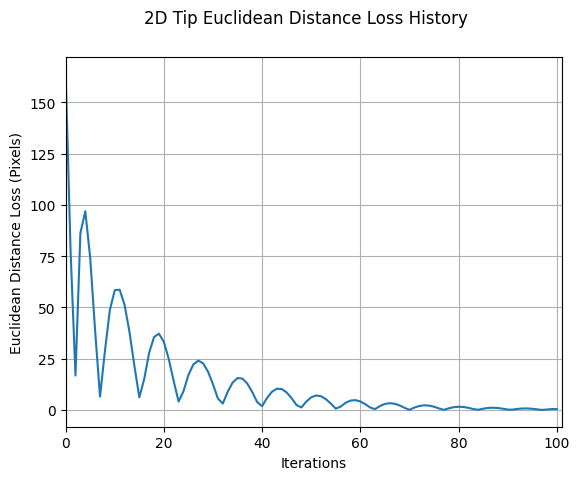

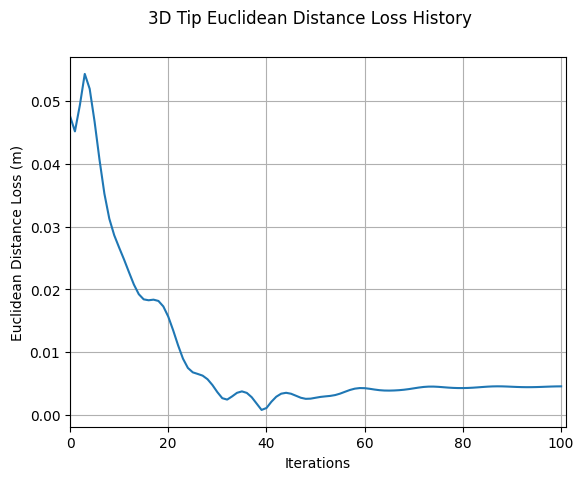

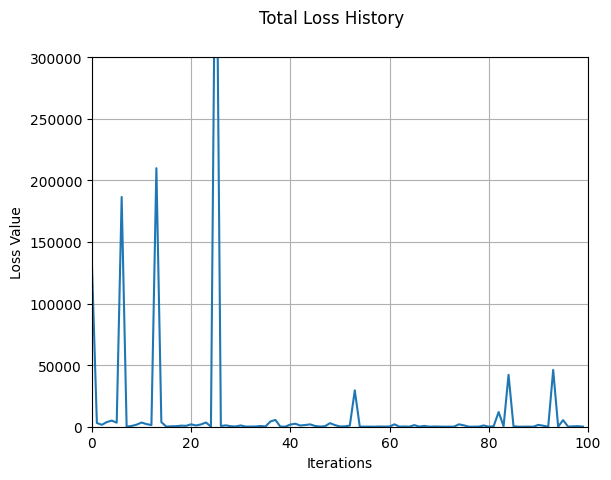

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:11,  1.33s/it, loss=3.73e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:09,  1.33s/it, loss=242]    


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:08,  1.32s/it, loss=4.94e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:06,  1.32s/it, loss=1.49e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:05,  1.32s/it, loss=894]    


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:02,  1.30s/it, loss=567]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:02,  1.31s/it, loss=561]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:01,  1.32s/it, loss=659]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<02:00,  1.33s/it, loss=647]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:00,  1.34s/it, loss=4.16e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:59,  1.35s/it, loss=327]    


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:57,  1.34s/it, loss=296]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:57,  1.35s/it, loss=330]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:58,  1.38s/it, loss=626]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:58,  1.39s/it, loss=255]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:55,  1.38s/it, loss=2.77e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:52,  1.36s/it, loss=558]    


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:52,  1.37s/it, loss=5.01e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:52,  1.38s/it, loss=690]    


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:49,  1.37s/it, loss=178]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:49,  1.39s/it, loss=1.74e+6]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:46,  1.37s/it, loss=226]    


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:46,  1.38s/it, loss=179]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:45,  1.39s/it, loss=199]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:42,  1.37s/it, loss=805]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:45,  1.43s/it, loss=77.7]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:43,  1.41s/it, loss=564] 


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:43,  1.44s/it, loss=508]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:43,  1.46s/it, loss=166]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:41<01:40,  1.44s/it, loss=690]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:38,  1.42s/it, loss=94.7]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:35,  1.40s/it, loss=286] 


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:45<01:32,  1.39s/it, loss=448]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:30,  1.37s/it, loss=1.27e+5]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:48<01:29,  1.38s/it, loss=829]    


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:28,  1.38s/it, loss=225]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:26,  1.38s/it, loss=277]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:52<01:25,  1.38s/it, loss=834]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:21,  1.34s/it, loss=495]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:19,  1.33s/it, loss=28.5]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:56<01:18,  1.34s/it, loss=458] 


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:19,  1.37s/it, loss=9.45e+8]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:17,  1.37s/it, loss=1.22e+4]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:15,  1.36s/it, loss=280]    


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:13,  1.34s/it, loss=6.05e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:13,  1.36s/it, loss=173]    


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:11,  1.34s/it, loss=74.6]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:09,  1.34s/it, loss=35.5]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:08,  1.34s/it, loss=3.33e+3]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:10,  1.40s/it, loss=70.8]   


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:08,  1.40s/it, loss=320] 


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:11<01:06,  1.38s/it, loss=125]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:05,  1.40s/it, loss=108]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:13<01:03,  1.39s/it, loss=278]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:02,  1.38s/it, loss=198]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<01:00,  1.38s/it, loss=71.7]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:18<00:59,  1.39s/it, loss=1.13e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:58,  1.39s/it, loss=142]    


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:56,  1.38s/it, loss=75.7]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:22<00:55,  1.39s/it, loss=86]  


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:23<00:53,  1.37s/it, loss=160]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:25<00:52,  1.38s/it, loss=1.71e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:26<00:51,  1.38s/it, loss=1.52e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:27<00:48,  1.36s/it, loss=505]    


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:29<00:48,  1.38s/it, loss=77.9]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:30<00:46,  1.37s/it, loss=75.2]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:31<00:45,  1.37s/it, loss=45.4]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:33<00:43,  1.35s/it, loss=63.3]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:34<00:41,  1.33s/it, loss=255] 


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:40,  1.36s/it, loss=4.44e+3]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:37<00:40,  1.38s/it, loss=1.43e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:38<00:38,  1.38s/it, loss=447]    


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:40<00:37,  1.39s/it, loss=135]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:41<00:36,  1.40s/it, loss=206]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:42<00:34,  1.39s/it, loss=217]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:44<00:33,  1.40s/it, loss=6.52e+3]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:45<00:32,  1.40s/it, loss=1.14e+4]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:47<00:30,  1.38s/it, loss=82.7]   


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:48<00:28,  1.37s/it, loss=212] 


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:49<00:27,  1.37s/it, loss=19.3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:51<00:27,  1.43s/it, loss=189] 


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:52<00:25,  1.40s/it, loss=254]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:54<00:23,  1.41s/it, loss=825]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:55<00:21,  1.37s/it, loss=1.02e+3]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:56<00:20,  1.35s/it, loss=23.7]   


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:58<00:19,  1.36s/it, loss=279] 


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:59<00:17,  1.35s/it, loss=54.3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:00<00:16,  1.38s/it, loss=889] 


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:02<00:15,  1.38s/it, loss=36.7]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:03<00:13,  1.38s/it, loss=99.7]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:05<00:12,  1.40s/it, loss=469] 


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:06<00:11,  1.41s/it, loss=92.7]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:07<00:09,  1.39s/it, loss=1.67e+3]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:09<00:08,  1.39s/it, loss=960]    


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:10<00:06,  1.39s/it, loss=164]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:11<00:05,  1.39s/it, loss=11.2]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:13<00:04,  1.38s/it, loss=7.77e+3]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:14<00:02,  1.38s/it, loss=28.6]   


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:16<00:01,  1.38s/it, loss=3.65e+4]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it, loss=318]   


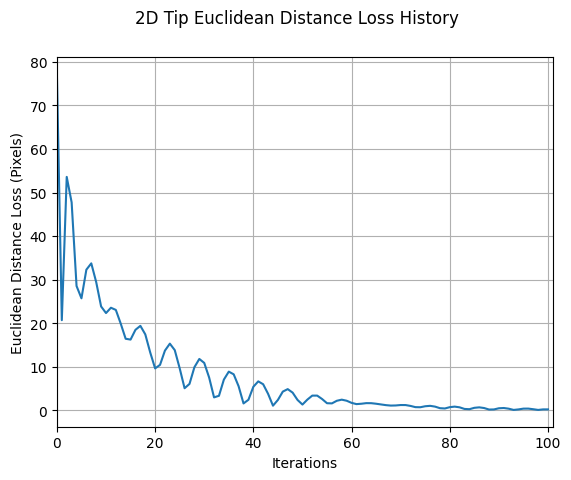

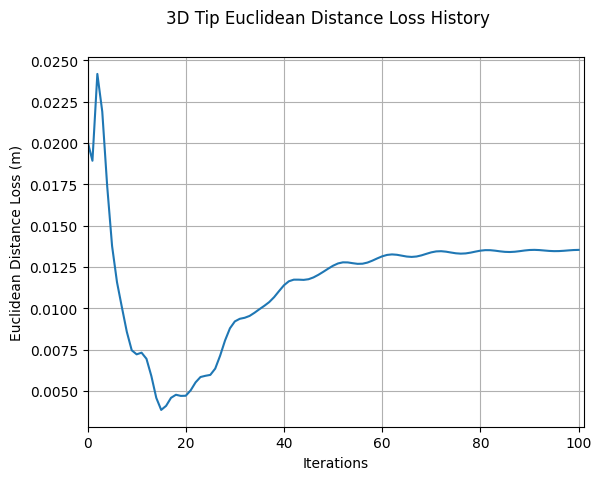

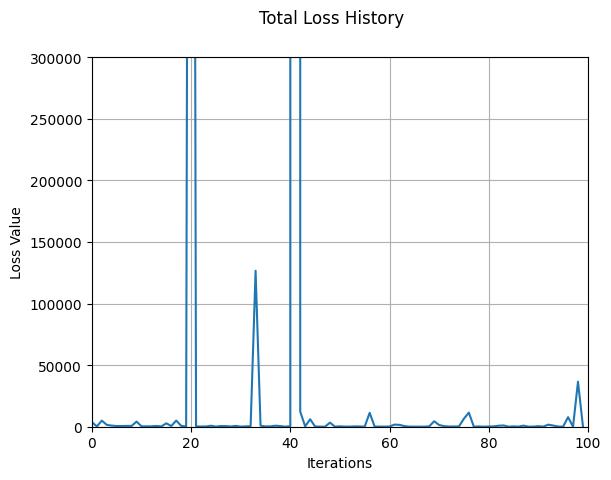

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:08,  1.29s/it, loss=3.18e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:07,  1.30s/it, loss=577]    


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:10,  1.35s/it, loss=1.76e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:06,  1.31s/it, loss=1.41e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:07,  1.34s/it, loss=422]    


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:08,  1.37s/it, loss=968]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:06,  1.36s/it, loss=1.09e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:05,  1.36s/it, loss=935]    


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:03,  1.36s/it, loss=1e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:02,  1.36s/it, loss=284]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<02:00,  1.35s/it, loss=216]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<01:59,  1.35s/it, loss=330]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:57,  1.35s/it, loss=797]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:56,  1.35s/it, loss=480]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:54,  1.35s/it, loss=506]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:54,  1.36s/it, loss=347]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:23<01:54,  1.38s/it, loss=104]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:57,  1.43s/it, loss=150]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:54,  1.41s/it, loss=348]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:51,  1.40s/it, loss=281]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:51,  1.42s/it, loss=1.45e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:30<01:49,  1.41s/it, loss=3.85e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:46,  1.38s/it, loss=90.5]   


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:44,  1.37s/it, loss=83.4]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:42,  1.37s/it, loss=158] 


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:42,  1.38s/it, loss=752]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:40,  1.37s/it, loss=701]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:37,  1.35s/it, loss=106]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:36,  1.36s/it, loss=511]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:34,  1.35s/it, loss=3.74e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:33,  1.35s/it, loss=514]    


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:29,  1.32s/it, loss=687]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:29,  1.34s/it, loss=2.16e+3]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:29,  1.36s/it, loss=28.7]   


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:27,  1.34s/it, loss=21.3]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:27,  1.37s/it, loss=85.6]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:26,  1.37s/it, loss=292] 


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:23,  1.35s/it, loss=71.3]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:22,  1.36s/it, loss=6.36e+4]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:24,  1.41s/it, loss=4.03e+4]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:56<01:23,  1.42s/it, loss=216]    


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:21,  1.40s/it, loss=98.5]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:18,  1.38s/it, loss=65.7]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:16,  1.37s/it, loss=3.97e+5]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:15,  1.37s/it, loss=53.5]   


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:13,  1.36s/it, loss=174] 


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:11,  1.35s/it, loss=215]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:08,  1.33s/it, loss=342]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:09,  1.36s/it, loss=1.4e+3]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:07,  1.35s/it, loss=89.2]  


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:06,  1.35s/it, loss=72.7]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:05,  1.36s/it, loss=620] 


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:03,  1.35s/it, loss=3.88e+4]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:13<01:01,  1.35s/it, loss=105]    


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:14<01:00,  1.34s/it, loss=5.56e+3]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<00:59,  1.35s/it, loss=6.03e+4]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:17<00:58,  1.35s/it, loss=1.08e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:18<00:55,  1.33s/it, loss=191]    


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:54,  1.34s/it, loss=57.1]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:21<00:53,  1.34s/it, loss=5.74e+3]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:22<00:51,  1.33s/it, loss=150]    


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:24<00:51,  1.35s/it, loss=3.29e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:25<00:49,  1.33s/it, loss=1.23e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:27<00:48,  1.35s/it, loss=84]     


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:47,  1.36s/it, loss=87.7]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:29<00:46,  1.35s/it, loss=1.02e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:31<00:45,  1.39s/it, loss=64]     


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:32<00:46,  1.44s/it, loss=1.81e+3]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:34<00:43,  1.41s/it, loss=1.32e+4]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:41,  1.40s/it, loss=5.3e+5] 


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:36<00:39,  1.37s/it, loss=370]   


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:38<00:37,  1.34s/it, loss=63.1]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:35,  1.33s/it, loss=92.4]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:40<00:34,  1.32s/it, loss=22.2]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:42<00:33,  1.33s/it, loss=18.1]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:43<00:31,  1.33s/it, loss=72.9]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:44<00:30,  1.34s/it, loss=104] 


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:29,  1.36s/it, loss=311]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:47<00:28,  1.34s/it, loss=31.2]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:48<00:26,  1.35s/it, loss=457] 


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:50<00:25,  1.34s/it, loss=234]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:51<00:24,  1.34s/it, loss=7.41e+4]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:52<00:22,  1.33s/it, loss=33]     


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:54<00:21,  1.32s/it, loss=124]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:55<00:19,  1.33s/it, loss=829]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:56<00:18,  1.33s/it, loss=25] 


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:58<00:17,  1.33s/it, loss=73.4]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:59<00:15,  1.33s/it, loss=133] 


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:00<00:14,  1.33s/it, loss=78.7]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:02<00:13,  1.32s/it, loss=116] 


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:03<00:11,  1.31s/it, loss=1.01e+4]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:04<00:10,  1.31s/it, loss=75.8]   


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:05<00:09,  1.31s/it, loss=3.87e+4]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:07<00:07,  1.32s/it, loss=59.5]   


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:08<00:06,  1.32s/it, loss=411] 


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:09<00:05,  1.32s/it, loss=776]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:11<00:04,  1.33s/it, loss=2.25e+3]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:12<00:02,  1.34s/it, loss=48.1]   


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:13<00:01,  1.33s/it, loss=39.3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:15<00:00,  1.35s/it, loss=152]


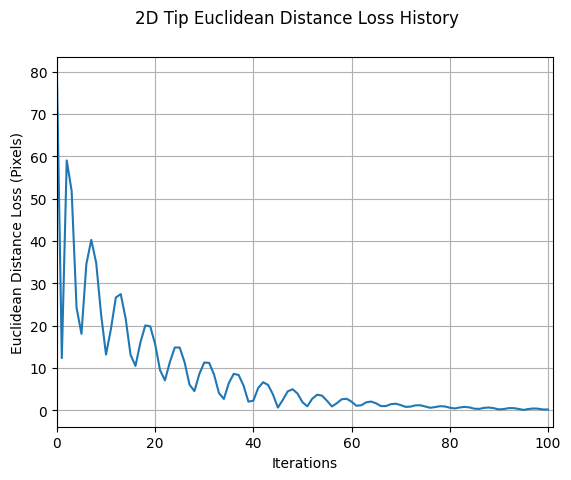

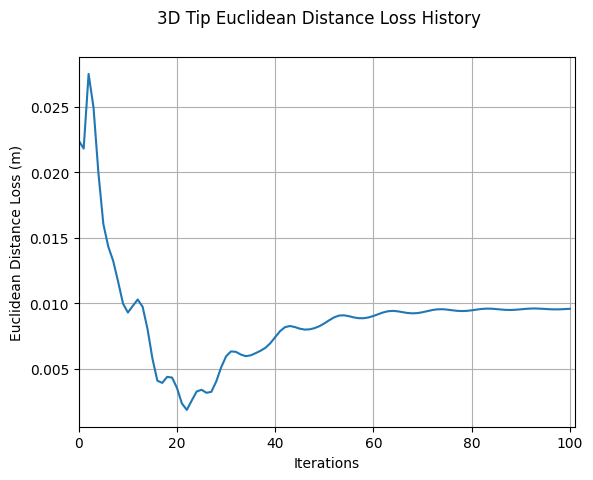

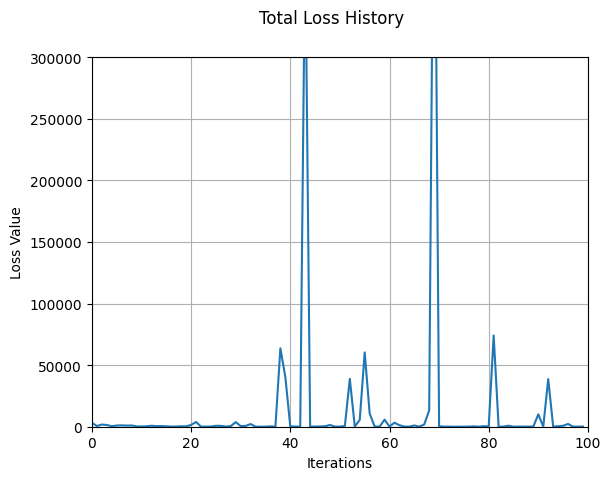

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:05,  1.27s/it, loss=155]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:14,  1.37s/it, loss=1.53e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:04<02:12,  1.37s/it, loss=393]    


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:10,  1.36s/it, loss=643]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:13,  1.40s/it, loss=858]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:12,  1.41s/it, loss=732]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:10,  1.40s/it, loss=1.37e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:11<02:06,  1.38s/it, loss=91.6]   


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:03,  1.36s/it, loss=405] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:03,  1.37s/it, loss=949]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:15<02:02,  1.37s/it, loss=1.78e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<02:01,  1.38s/it, loss=206]    


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<02:01,  1.40s/it, loss=6.76e+4]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:19<01:58,  1.37s/it, loss=3.5e+4] 


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:56,  1.37s/it, loss=232]   


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:54,  1.36s/it, loss=225]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:23<01:53,  1.36s/it, loss=2.51e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:50,  1.35s/it, loss=3.58e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:26<01:49,  1.36s/it, loss=500]    


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:47,  1.35s/it, loss=67] 


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:50,  1.40s/it, loss=242]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:30<01:49,  1.40s/it, loss=347]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:46,  1.39s/it, loss=288]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:33<01:45,  1.38s/it, loss=290]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:42,  1.37s/it, loss=71.2]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:40,  1.36s/it, loss=67.3]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:37<01:39,  1.37s/it, loss=327] 


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:37,  1.35s/it, loss=369]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:36,  1.36s/it, loss=287]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:41<01:34,  1.35s/it, loss=18] 


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:33,  1.36s/it, loss=383]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:32,  1.36s/it, loss=50.6]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:45<01:31,  1.37s/it, loss=83.3]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:30,  1.37s/it, loss=984] 


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:28,  1.36s/it, loss=164]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:26,  1.35s/it, loss=6.88e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:25,  1.36s/it, loss=55.9]   


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:52<01:25,  1.37s/it, loss=122] 


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:24,  1.38s/it, loss=32.8]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:22,  1.38s/it, loss=46.3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:56<01:20,  1.37s/it, loss=1.66e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:19,  1.38s/it, loss=1.01e+4]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:59<01:19,  1.40s/it, loss=284]    


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:21,  1.46s/it, loss=418]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:17,  1.41s/it, loss=3.91e+4]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:03<01:15,  1.40s/it, loss=107]    


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:14,  1.40s/it, loss=622]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:06<01:12,  1.39s/it, loss=27.1]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:07<01:11,  1.41s/it, loss=153] 


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:09,  1.40s/it, loss=44.9]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:10<01:08,  1.39s/it, loss=5.48e+3]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:11<01:06,  1.38s/it, loss=290]    


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:04,  1.37s/it, loss=192]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:14<01:02,  1.37s/it, loss=372]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:01,  1.36s/it, loss=557]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:17<00:59,  1.35s/it, loss=467]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:18<00:58,  1.35s/it, loss=3.18e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:57,  1.37s/it, loss=4.24e+3]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:21<00:56,  1.37s/it, loss=120]    


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:22<00:55,  1.38s/it, loss=51.2]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:24<00:54,  1.41s/it, loss=645] 


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:25<00:53,  1.40s/it, loss=1.12e+4]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:26<00:51,  1.39s/it, loss=25.8]   


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:28<00:49,  1.37s/it, loss=5.97e+3]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:29<00:47,  1.37s/it, loss=207]    


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:30<00:46,  1.36s/it, loss=5.06e+6]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:32<00:44,  1.34s/it, loss=71.8]   


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:33<00:42,  1.34s/it, loss=333] 


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:34<00:41,  1.32s/it, loss=607]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:36<00:40,  1.34s/it, loss=183]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:37<00:38,  1.33s/it, loss=97.9]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:38<00:37,  1.34s/it, loss=550] 


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:40<00:38,  1.42s/it, loss=260]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:41<00:36,  1.40s/it, loss=3.78e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:43<00:34,  1.39s/it, loss=852]    


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:44<00:32,  1.37s/it, loss=71.5]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:45<00:31,  1.36s/it, loss=17.1]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:47<00:29,  1.35s/it, loss=473] 


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:48<00:28,  1.37s/it, loss=38.4]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:49<00:27,  1.37s/it, loss=542] 


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:51<00:25,  1.35s/it, loss=2.65e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:52<00:24,  1.34s/it, loss=112]    


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:53<00:22,  1.31s/it, loss=125]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:55<00:20,  1.31s/it, loss=6.24e+5]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:56<00:20,  1.34s/it, loss=110]    


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:57<00:18,  1.33s/it, loss=626]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:59<00:17,  1.36s/it, loss=25.8]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:00<00:16,  1.35s/it, loss=57.5]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:01<00:14,  1.36s/it, loss=402] 


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:03<00:13,  1.35s/it, loss=222]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:04<00:12,  1.34s/it, loss=2.11e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:05<00:10,  1.34s/it, loss=2.18e+4]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:07<00:09,  1.35s/it, loss=144]    


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:08<00:08,  1.35s/it, loss=25.2]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:09<00:06,  1.35s/it, loss=9.8e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:11<00:05,  1.34s/it, loss=3.12e+7]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:12<00:04,  1.34s/it, loss=246]    


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:13<00:02,  1.34s/it, loss=5.15e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:15<00:01,  1.36s/it, loss=7.27e+4]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:16<00:00,  1.37s/it, loss=48.7]  


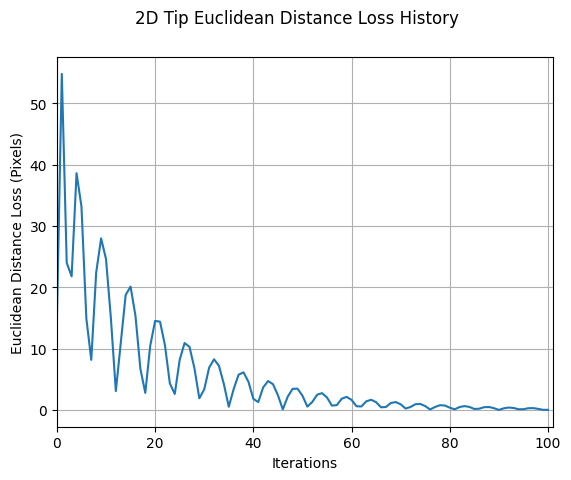

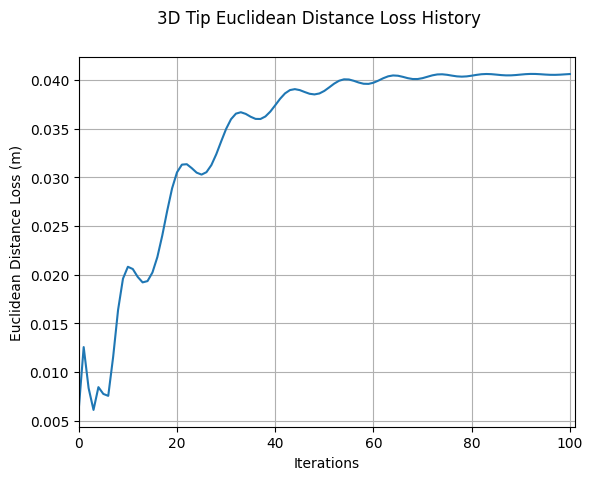

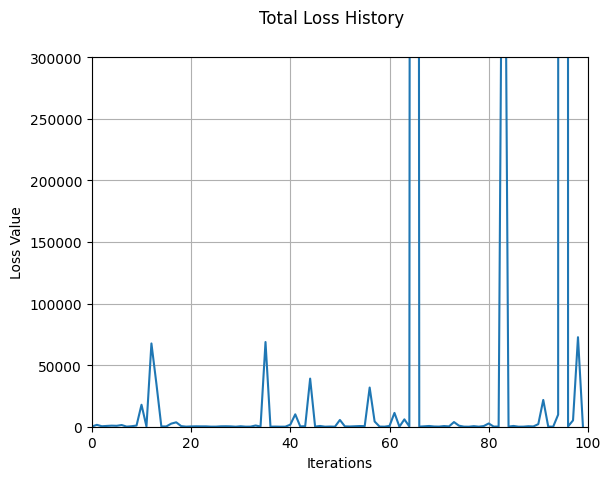

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:10,  1.32s/it, loss=197]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:09,  1.32s/it, loss=2.69e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:04<02:12,  1.37s/it, loss=190]    


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:10,  1.36s/it, loss=466]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:11,  1.38s/it, loss=1.34e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:10,  1.39s/it, loss=1.16e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:04,  1.34s/it, loss=411]    


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:06,  1.38s/it, loss=230]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:09,  1.43s/it, loss=343]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:05,  1.40s/it, loss=3.79e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:15<02:01,  1.37s/it, loss=582]    


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<02:01,  1.38s/it, loss=326]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:58,  1.36s/it, loss=119]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:19<01:58,  1.38s/it, loss=127]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:56,  1.37s/it, loss=455]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:54,  1.37s/it, loss=563]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:23<01:52,  1.35s/it, loss=258]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:51,  1.36s/it, loss=176]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:26<01:49,  1.35s/it, loss=627]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:49,  1.36s/it, loss=6.6e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:47,  1.36s/it, loss=165]   


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:30<01:47,  1.38s/it, loss=236]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:47,  1.40s/it, loss=525]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:44,  1.37s/it, loss=72.9]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:42,  1.37s/it, loss=320] 


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:40,  1.36s/it, loss=751]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:37<01:39,  1.37s/it, loss=135]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:38,  1.37s/it, loss=87.4]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:40,  1.41s/it, loss=300] 


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:41<01:37,  1.39s/it, loss=447]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:35,  1.38s/it, loss=88.6]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:34,  1.38s/it, loss=147] 


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:45<01:31,  1.37s/it, loss=87.4]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:31,  1.38s/it, loss=47.2]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:48<01:29,  1.37s/it, loss=217] 


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:26,  1.35s/it, loss=143]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:26,  1.37s/it, loss=3.39e+3]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:52<01:24,  1.36s/it, loss=213]    


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:22,  1.35s/it, loss=107]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:21,  1.36s/it, loss=1.08e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:56<01:20,  1.36s/it, loss=2.35e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:18,  1.35s/it, loss=672]    


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:17,  1.36s/it, loss=7.18e+3]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:16,  1.36s/it, loss=446]    


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:14,  1.35s/it, loss=67.4]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:03<01:13,  1.37s/it, loss=6.05e+4]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:12,  1.37s/it, loss=90.2]   


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:10,  1.36s/it, loss=244] 


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:07<01:10,  1.38s/it, loss=447]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:08,  1.37s/it, loss=735]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:07,  1.38s/it, loss=36.1]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:11<01:06,  1.39s/it, loss=1.18e+3]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:04,  1.38s/it, loss=99.6]   


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:14<01:06,  1.45s/it, loss=57]  


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:04,  1.42s/it, loss=148]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:17<01:01,  1.40s/it, loss=41.1]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:18<00:59,  1.39s/it, loss=109] 


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:58,  1.38s/it, loss=6.86e+3]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:21<00:56,  1.37s/it, loss=71.7]   


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:22<00:54,  1.37s/it, loss=573] 


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:23<00:53,  1.36s/it, loss=192]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:25<00:51,  1.36s/it, loss=30.1]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:26<00:50,  1.36s/it, loss=517] 


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:27<00:48,  1.36s/it, loss=333]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:29<00:46,  1.33s/it, loss=139]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:30<00:46,  1.37s/it, loss=19.4]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:31<00:44,  1.35s/it, loss=82.6]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:33<00:43,  1.34s/it, loss=153] 


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:34<00:41,  1.35s/it, loss=1.71e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:40,  1.35s/it, loss=207]    


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:37<00:39,  1.36s/it, loss=36.2]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:38<00:37,  1.35s/it, loss=492] 


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:36,  1.34s/it, loss=78.6]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:41<00:35,  1.35s/it, loss=155] 


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:42<00:33,  1.32s/it, loss=176]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:43<00:31,  1.33s/it, loss=188]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:45<00:30,  1.33s/it, loss=106]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:29,  1.35s/it, loss=87.2]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:48<00:28,  1.36s/it, loss=5.28e+4]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:49<00:27,  1.37s/it, loss=4.86e+4]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:50<00:26,  1.39s/it, loss=18.5]   


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:52<00:25,  1.41s/it, loss=1.9e+4]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:53<00:23,  1.40s/it, loss=108]   


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:55<00:22,  1.40s/it, loss=639]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:56<00:22,  1.48s/it, loss=1.4e+3]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:58<00:20,  1.45s/it, loss=1.7e+3]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:59<00:18,  1.43s/it, loss=303]   


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:00<00:17,  1.43s/it, loss=124]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:02<00:15,  1.42s/it, loss=41.2]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:03<00:14,  1.44s/it, loss=707] 


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:05<00:12,  1.42s/it, loss=22.2]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:06<00:11,  1.43s/it, loss=57.1]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:07<00:09,  1.39s/it, loss=1.66e+3]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:09<00:08,  1.41s/it, loss=601]    


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:10<00:07,  1.42s/it, loss=314]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:12<00:05,  1.41s/it, loss=2.53e+3]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:13<00:04,  1.40s/it, loss=285]    


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:15<00:02,  1.40s/it, loss=320]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:16<00:01,  1.40s/it, loss=22.4]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:17<00:00,  1.38s/it, loss=1.07e+4]


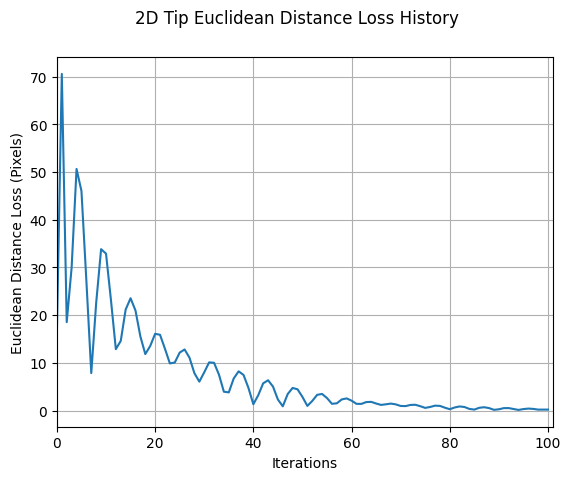

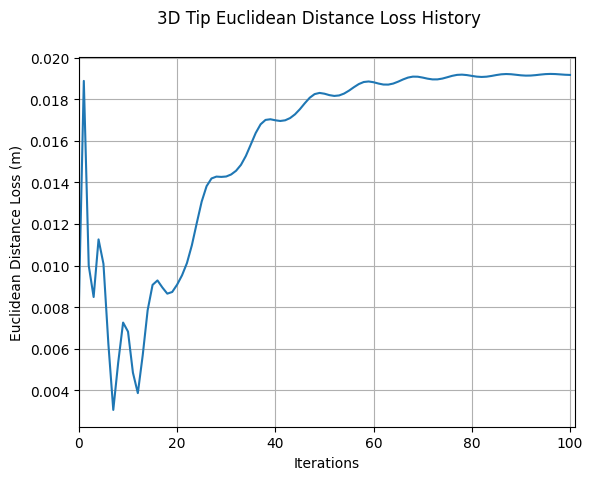

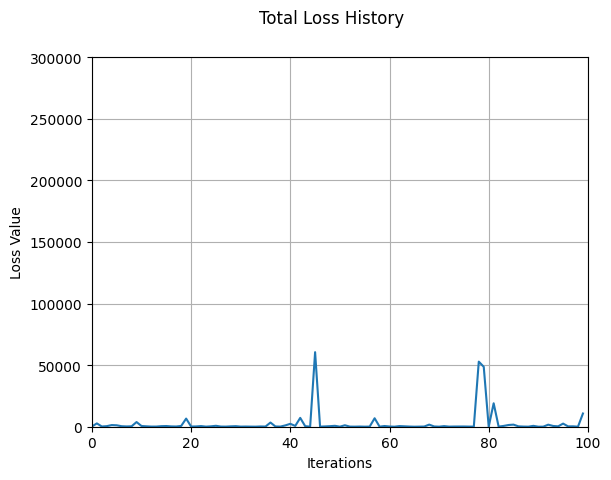

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:14,  1.36s/it, loss=1.3e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:10,  1.33s/it, loss=403]   


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:04<02:10,  1.35s/it, loss=707]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:09,  1.35s/it, loss=1.75e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:15,  1.43s/it, loss=117]    


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:15,  1.44s/it, loss=179]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:13,  1.43s/it, loss=414]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:11<02:11,  1.43s/it, loss=316]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:08,  1.41s/it, loss=343]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:14<02:06,  1.41s/it, loss=27.6]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:15<02:02,  1.38s/it, loss=394] 


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<02:00,  1.37s/it, loss=2.88e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:18<01:59,  1.38s/it, loss=255]    


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:19<01:58,  1.38s/it, loss=196]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:57,  1.39s/it, loss=3.59e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:22<01:55,  1.37s/it, loss=30.5]   


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:23<01:53,  1.37s/it, loss=73.1]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:50,  1.35s/it, loss=113] 


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:26<01:49,  1.35s/it, loss=119]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:47,  1.35s/it, loss=803]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:47,  1.36s/it, loss=263]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:30<01:51,  1.43s/it, loss=30.6]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:48,  1.41s/it, loss=162] 


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:33<01:48,  1.42s/it, loss=111]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:45,  1.40s/it, loss=57.3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:36<01:42,  1.39s/it, loss=124] 


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:37<01:41,  1.39s/it, loss=142]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:40,  1.39s/it, loss=107]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:40<01:38,  1.39s/it, loss=285]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:41<01:37,  1.40s/it, loss=70.2]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:43<01:37,  1.41s/it, loss=168] 


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:44<01:35,  1.40s/it, loss=448]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:45<01:33,  1.39s/it, loss=715]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:47<01:31,  1.38s/it, loss=35.1]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:48<01:27,  1.34s/it, loss=88.3]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:27,  1.37s/it, loss=214] 


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:51<01:26,  1.37s/it, loss=784]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:52<01:23,  1.34s/it, loss=794]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:23,  1.36s/it, loss=24.1]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:55<01:21,  1.36s/it, loss=50]  


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:56<01:20,  1.36s/it, loss=23.4]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:58<01:18,  1.36s/it, loss=185] 


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:59<01:17,  1.36s/it, loss=1.55e+3]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:01<01:20,  1.44s/it, loss=26.2]   


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:02<01:18,  1.43s/it, loss=78.6]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:03<01:17,  1.43s/it, loss=372] 


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:05<01:15,  1.43s/it, loss=92.7]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:06<01:13,  1.42s/it, loss=79.3]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:08<01:11,  1.41s/it, loss=52]  


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:09<01:09,  1.39s/it, loss=148]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:10<01:07,  1.38s/it, loss=23] 


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:12<01:05,  1.37s/it, loss=38.8]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:13<01:04,  1.37s/it, loss=2.75e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:14<01:04,  1.39s/it, loss=50.6]   


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:16<01:02,  1.38s/it, loss=28.4]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:17<01:00,  1.38s/it, loss=57.7]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:19<00:59,  1.38s/it, loss=53.8]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:20<00:57,  1.37s/it, loss=27.9]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:21<00:55,  1.36s/it, loss=85.4]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:23<00:54,  1.36s/it, loss=827] 


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:24<00:53,  1.38s/it, loss=1.59e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:25<00:52,  1.37s/it, loss=832]    


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:27<00:50,  1.37s/it, loss=4.47e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:28<00:49,  1.37s/it, loss=211]    


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:29<00:48,  1.38s/it, loss=139]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:31<00:46,  1.38s/it, loss=172]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:32<00:45,  1.37s/it, loss=140]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:34<00:43,  1.37s/it, loss=53.1]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:35<00:42,  1.38s/it, loss=1.84e+4]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:36<00:41,  1.39s/it, loss=986]    


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:38<00:39,  1.38s/it, loss=2.04e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:39<00:38,  1.37s/it, loss=33.9]   


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:41<00:37,  1.38s/it, loss=273] 


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:42<00:37,  1.44s/it, loss=64] 


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:43<00:35,  1.43s/it, loss=628]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:45<00:33,  1.39s/it, loss=114]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:46<00:31,  1.38s/it, loss=169]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:48<00:30,  1.39s/it, loss=1.38e+3]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:49<00:29,  1.38s/it, loss=1.33e+4]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:50<00:27,  1.39s/it, loss=2.92e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:52<00:26,  1.40s/it, loss=191]    


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:53<00:25,  1.40s/it, loss=336]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:55<00:23,  1.39s/it, loss=5.92e+3]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:56<00:22,  1.40s/it, loss=48.4]   


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:57<00:21,  1.41s/it, loss=17.4]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:59<00:19,  1.40s/it, loss=47.5]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [02:00<00:18,  1.39s/it, loss=579] 


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:02<00:16,  1.40s/it, loss=3.51e+3]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:03<00:15,  1.39s/it, loss=44.5]   


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:04<00:14,  1.41s/it, loss=363] 


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:06<00:12,  1.38s/it, loss=204]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:07<00:11,  1.41s/it, loss=6.08e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:09<00:09,  1.41s/it, loss=612]    


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:10<00:08,  1.43s/it, loss=59.9]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:11<00:07,  1.44s/it, loss=282] 


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:13<00:05,  1.42s/it, loss=144]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:14<00:04,  1.40s/it, loss=22.2]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:16<00:02,  1.39s/it, loss=962] 


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:17<00:01,  1.38s/it, loss=179]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it, loss=94.7]


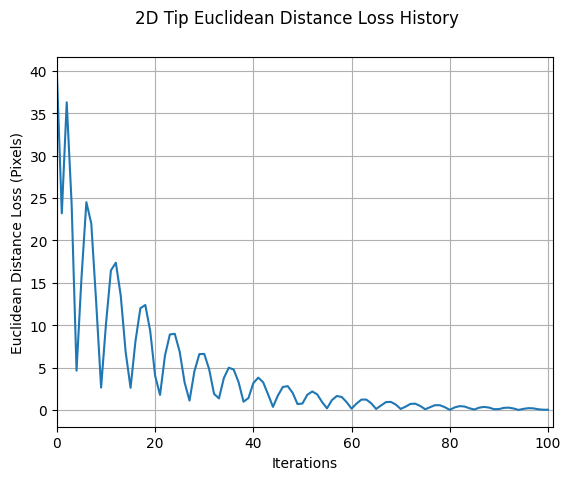

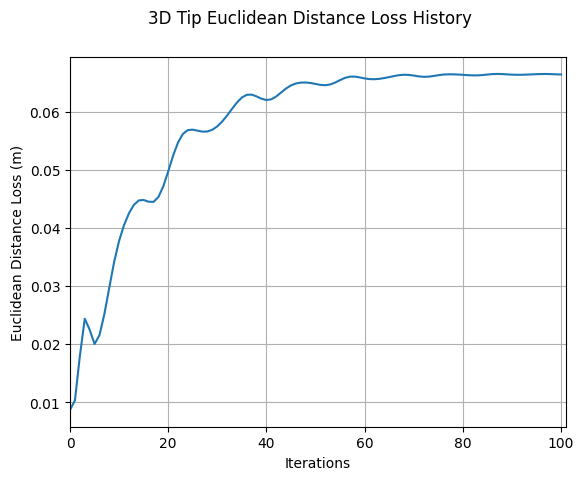

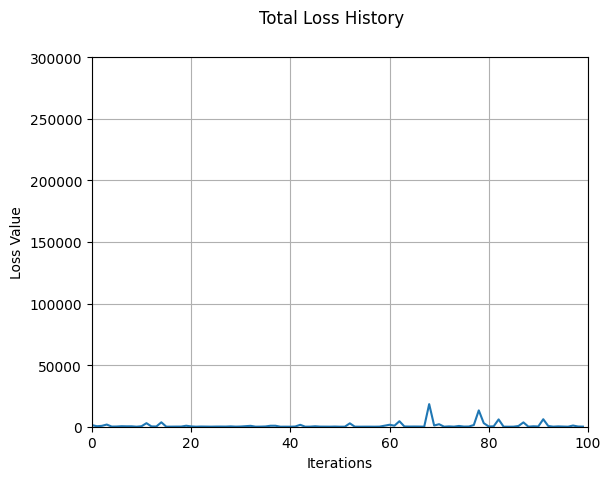

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:13,  1.35s/it, loss=3.23e+4]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:13,  1.37s/it, loss=801]    


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:04<02:17,  1.42s/it, loss=1.1e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:11,  1.37s/it, loss=349]   


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:09,  1.37s/it, loss=200]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:10,  1.38s/it, loss=768]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:08,  1.38s/it, loss=557]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:11<02:08,  1.39s/it, loss=2.04e+4]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:09,  1.43s/it, loss=292]    


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:14<02:08,  1.42s/it, loss=144]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:15<02:02,  1.37s/it, loss=183]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<02:02,  1.39s/it, loss=492]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:18<02:01,  1.40s/it, loss=259]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:19<01:56,  1.36s/it, loss=149]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:56,  1.37s/it, loss=52] 


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:22<01:55,  1.38s/it, loss=56.4]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:23<01:54,  1.37s/it, loss=113] 


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:52,  1.37s/it, loss=294]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:26<01:51,  1.38s/it, loss=114]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:51,  1.39s/it, loss=1.1e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:29<01:50,  1.40s/it, loss=1.6e+4]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:30<01:48,  1.40s/it, loss=65]    


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:45,  1.38s/it, loss=69.4]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:33<01:46,  1.40s/it, loss=222] 


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:44,  1.39s/it, loss=154]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:36<01:42,  1.39s/it, loss=93.4]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:37<01:42,  1.40s/it, loss=59.4]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:40,  1.40s/it, loss=312] 


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:40<01:43,  1.46s/it, loss=100]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:41<01:40,  1.44s/it, loss=192]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:43<01:38,  1.43s/it, loss=823]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:44<01:35,  1.41s/it, loss=287]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:46<01:35,  1.42s/it, loss=3.26e+3]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:47<01:33,  1.42s/it, loss=61]     


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:48<01:31,  1.40s/it, loss=237]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:50<01:30,  1.42s/it, loss=123]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:51<01:30,  1.44s/it, loss=443]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:53<01:28,  1.43s/it, loss=166]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:54<01:27,  1.43s/it, loss=16.3]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:56<01:25,  1.42s/it, loss=1.07e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:57<01:23,  1.41s/it, loss=112]    


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:58<01:22,  1.42s/it, loss=2.06e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [01:00<01:18,  1.38s/it, loss=52.1]   


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:01<01:17,  1.39s/it, loss=1.7e+3]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:02<01:15,  1.37s/it, loss=1.08e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:04<01:15,  1.40s/it, loss=46.7]   


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:05<01:14,  1.40s/it, loss=119] 


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:07<01:12,  1.40s/it, loss=55] 


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:08<01:11,  1.40s/it, loss=71.1]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:09<01:09,  1.40s/it, loss=265] 


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:11<01:08,  1.39s/it, loss=142]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:12<01:05,  1.37s/it, loss=189]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:14<01:05,  1.38s/it, loss=118]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:15<01:03,  1.37s/it, loss=2.61e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:17<01:04,  1.44s/it, loss=209]    


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:18<01:02,  1.43s/it, loss=16.1]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:19<01:02,  1.44s/it, loss=278] 


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:21<01:00,  1.45s/it, loss=692]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:22<00:58,  1.42s/it, loss=91] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:24<00:55,  1.40s/it, loss=755]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:25<00:56,  1.45s/it, loss=324]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:26<00:53,  1.41s/it, loss=72] 


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:28<00:51,  1.40s/it, loss=17.5]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:29<00:49,  1.37s/it, loss=170] 


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:31<00:48,  1.38s/it, loss=106]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:32<00:46,  1.38s/it, loss=41.4]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:33<00:45,  1.37s/it, loss=28.8]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:35<00:43,  1.36s/it, loss=37.4]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:36<00:41,  1.35s/it, loss=539] 


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:37<00:40,  1.34s/it, loss=563]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:39<00:39,  1.36s/it, loss=115]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:40<00:37,  1.34s/it, loss=211]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:41<00:36,  1.34s/it, loss=772]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:43<00:34,  1.34s/it, loss=122]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:44<00:33,  1.34s/it, loss=562]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:45<00:31,  1.33s/it, loss=187]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:47<00:31,  1.35s/it, loss=5.45e+3]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:48<00:29,  1.34s/it, loss=151]    


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:49<00:28,  1.35s/it, loss=2.6e+3]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:51<00:26,  1.34s/it, loss=347]   


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:52<00:25,  1.34s/it, loss=2.04e+4]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:53<00:23,  1.33s/it, loss=43.3]   


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:55<00:22,  1.35s/it, loss=1.33e+3]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:56<00:21,  1.36s/it, loss=187]    


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:57<00:20,  1.36s/it, loss=63.7]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:59<00:19,  1.37s/it, loss=854] 


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [02:00<00:18,  1.45s/it, loss=165]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:02<00:16,  1.41s/it, loss=13.8]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:03<00:15,  1.39s/it, loss=157] 


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:05<00:13,  1.40s/it, loss=49.2]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:06<00:12,  1.37s/it, loss=509] 


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:07<00:11,  1.38s/it, loss=148]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:09<00:09,  1.37s/it, loss=119]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:10<00:08,  1.36s/it, loss=27.5]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:11<00:06,  1.37s/it, loss=1.29e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:13<00:05,  1.37s/it, loss=41.8]   


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:14<00:04,  1.37s/it, loss=24.2]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:15<00:02,  1.36s/it, loss=1.4e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:17<00:01,  1.36s/it, loss=1.48e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it, loss=3.02e+4]


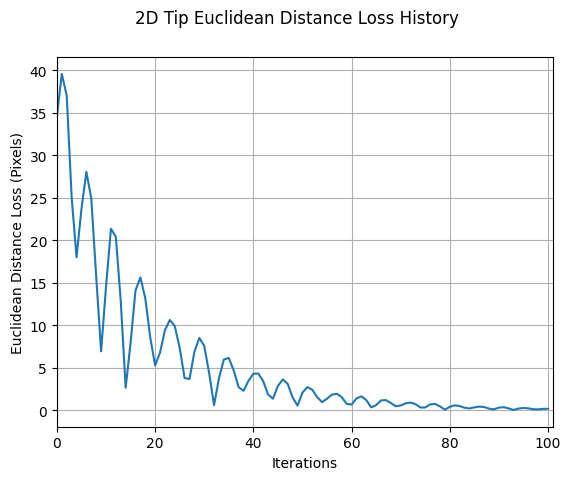

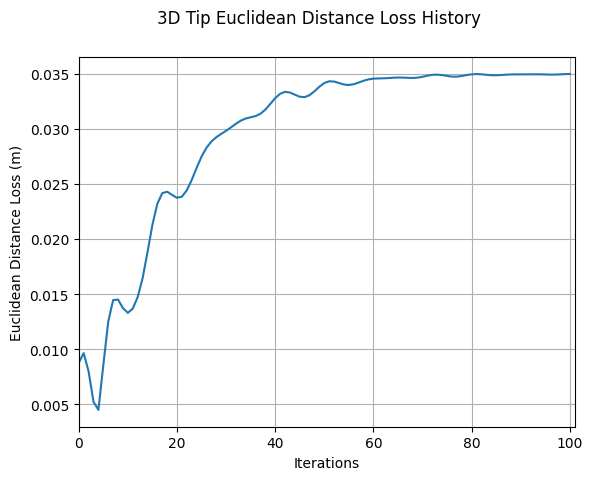

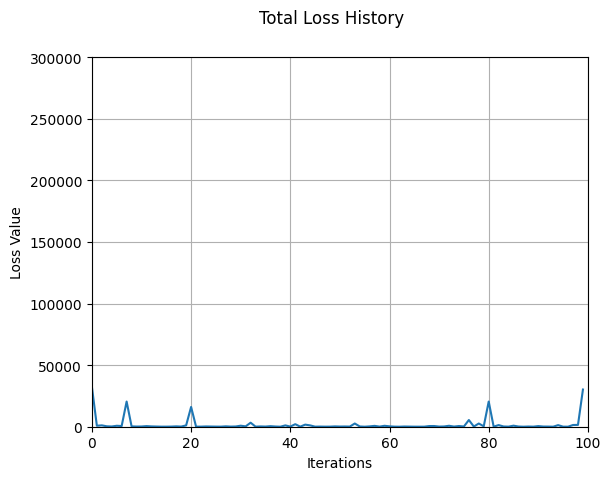

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:05,  1.26s/it, loss=1.94e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:09,  1.32s/it, loss=501]    


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:06,  1.30s/it, loss=705]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:08,  1.34s/it, loss=1.03e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:16,  1.44s/it, loss=502]    


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:14,  1.43s/it, loss=146]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:07,  1.37s/it, loss=213]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:05,  1.37s/it, loss=2.95e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:01,  1.34s/it, loss=615]    


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:01,  1.35s/it, loss=263]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<02:00,  1.36s/it, loss=245]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<01:59,  1.36s/it, loss=383]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:56,  1.33s/it, loss=321]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:55,  1.34s/it, loss=2.58e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:54,  1.34s/it, loss=247]    


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:52,  1.34s/it, loss=373]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:23<01:51,  1.35s/it, loss=1.42e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:49,  1.33s/it, loss=6.04e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:49,  1.35s/it, loss=50.6]   


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:46,  1.33s/it, loss=959] 


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:46,  1.34s/it, loss=107]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:45,  1.35s/it, loss=6.56e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:43,  1.34s/it, loss=476]    


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:40,  1.32s/it, loss=86.6]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:45,  1.41s/it, loss=118] 


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:43,  1.40s/it, loss=111]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:40,  1.38s/it, loss=112]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:35,  1.33s/it, loss=854]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:35,  1.34s/it, loss=124]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:35,  1.37s/it, loss=86.7]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:34,  1.37s/it, loss=50.7]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:34,  1.39s/it, loss=1.1e+3]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:32,  1.38s/it, loss=43.2]  


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:31,  1.38s/it, loss=87.1]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:28,  1.36s/it, loss=1.39e+3]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:48<01:27,  1.36s/it, loss=1.51e+3]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:25,  1.36s/it, loss=110]    


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:23,  1.34s/it, loss=29.8]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:52<01:22,  1.35s/it, loss=364] 


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:20,  1.34s/it, loss=809]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:19,  1.35s/it, loss=190]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:56<01:19,  1.36s/it, loss=3.29e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:18,  1.37s/it, loss=41.3]   


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:15,  1.35s/it, loss=81.1]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:14,  1.35s/it, loss=75.6]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:12,  1.35s/it, loss=66.7]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:03<01:12,  1.36s/it, loss=34.1]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:10,  1.36s/it, loss=465] 


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:12,  1.43s/it, loss=72] 


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:10,  1.41s/it, loss=140]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:08,  1.41s/it, loss=5.78e+3]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:06,  1.39s/it, loss=216]    


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:02,  1.34s/it, loss=27.1]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:13<01:02,  1.35s/it, loss=138] 


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:14<01:00,  1.34s/it, loss=127]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<00:59,  1.35s/it, loss=45.9]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:17<00:57,  1.35s/it, loss=137] 


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:18<00:56,  1.36s/it, loss=57.4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:55,  1.35s/it, loss=128] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:21<00:54,  1.36s/it, loss=4.25e+3]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:23<00:53,  1.38s/it, loss=118]    


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:24<00:52,  1.38s/it, loss=135]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:25<00:50,  1.36s/it, loss=7.01e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:26<00:47,  1.31s/it, loss=71]     


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:46,  1.33s/it, loss=44.4]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:29<00:45,  1.33s/it, loss=113] 


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:30<00:44,  1.35s/it, loss=147]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:32<00:43,  1.36s/it, loss=154]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:33<00:42,  1.36s/it, loss=88.7]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:40,  1.35s/it, loss=593] 


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:36<00:39,  1.36s/it, loss=61.4]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:37<00:37,  1.35s/it, loss=1.53e+3]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:36,  1.35s/it, loss=54.2]   


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:40<00:34,  1.34s/it, loss=947] 


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:41<00:33,  1.32s/it, loss=101]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:43<00:32,  1.35s/it, loss=99.8]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:44<00:30,  1.34s/it, loss=3.64e+5]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:31,  1.43s/it, loss=659]    


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:47<00:29,  1.40s/it, loss=390]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:48<00:27,  1.38s/it, loss=1.34e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:50<00:26,  1.38s/it, loss=6.12e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:51<00:25,  1.39s/it, loss=53.7]   


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:52<00:23,  1.38s/it, loss=6.62e+5]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:54<00:22,  1.38s/it, loss=209]    


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:55<00:20,  1.35s/it, loss=34.3]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:56<00:18,  1.35s/it, loss=680] 


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:58<00:17,  1.33s/it, loss=41.8]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:59<00:16,  1.34s/it, loss=970] 


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:00<00:14,  1.34s/it, loss=668]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:02<00:13,  1.33s/it, loss=2.75e+3]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:03<00:12,  1.36s/it, loss=85.5]   


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:05<00:10,  1.36s/it, loss=145] 


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:06<00:09,  1.37s/it, loss=187]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:07<00:08,  1.37s/it, loss=33.5]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:09<00:06,  1.36s/it, loss=51.1]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:10<00:05,  1.36s/it, loss=764] 


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:11<00:04,  1.35s/it, loss=168]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:13<00:02,  1.37s/it, loss=258]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:14<00:01,  1.37s/it, loss=571]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:15<00:00,  1.36s/it, loss=60]


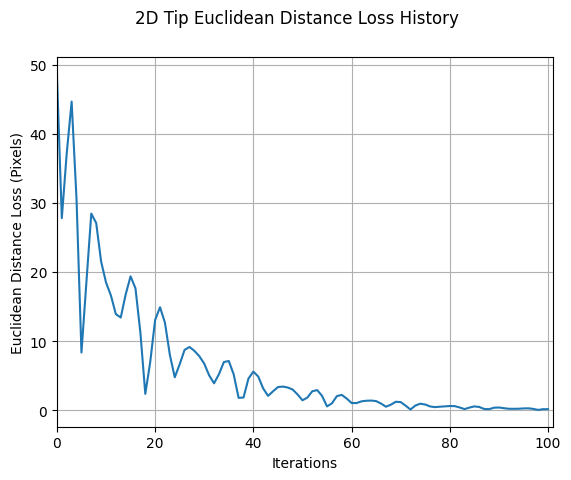

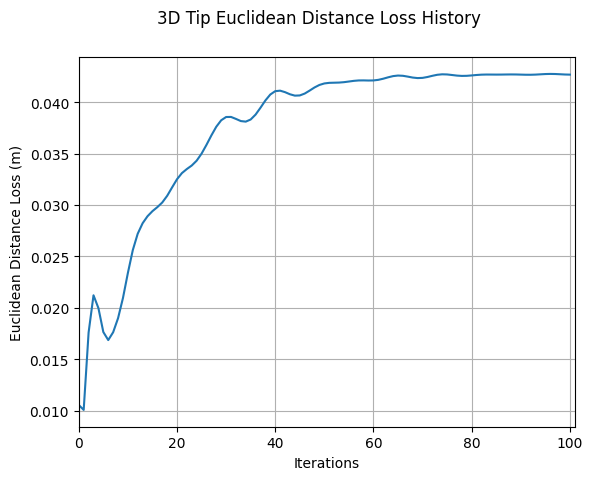

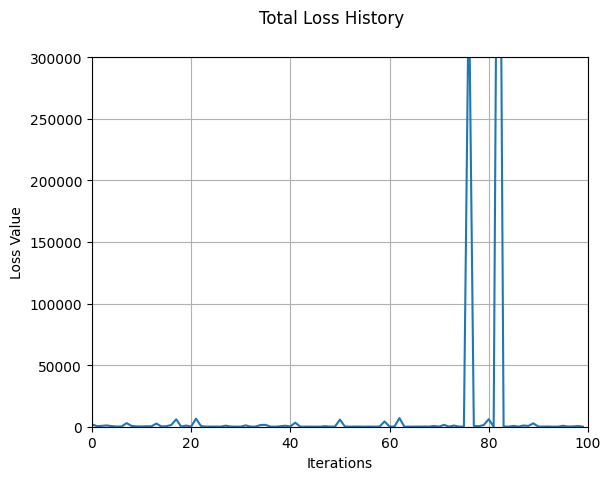

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:04,  1.25s/it, loss=2.8e+4]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:05,  1.28s/it, loss=1.17e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:05,  1.29s/it, loss=545]    


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:07,  1.32s/it, loss=612]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:05,  1.32s/it, loss=344]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:04,  1.32s/it, loss=285]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:04,  1.34s/it, loss=2.62e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:06,  1.37s/it, loss=243]    


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<02:02,  1.35s/it, loss=1.04e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<01:59,  1.33s/it, loss=652]   


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:55,  1.30s/it, loss=271]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:54,  1.30s/it, loss=142]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:54,  1.32s/it, loss=1.05e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:58,  1.38s/it, loss=75.4]   


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:57,  1.38s/it, loss=89.3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:54,  1.36s/it, loss=456] 


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:53,  1.37s/it, loss=152]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:50,  1.35s/it, loss=744]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:50,  1.36s/it, loss=120]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:48,  1.36s/it, loss=54.3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:49,  1.38s/it, loss=69.7]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:45,  1.36s/it, loss=170] 


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:30<01:44,  1.36s/it, loss=268]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:47,  1.41s/it, loss=954]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:45,  1.41s/it, loss=198]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:43,  1.40s/it, loss=1.41e+5]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:42,  1.41s/it, loss=7.41e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:40,  1.39s/it, loss=67.9]   


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:37,  1.37s/it, loss=67.5]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:36,  1.38s/it, loss=333] 


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:35,  1.39s/it, loss=104]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:33,  1.37s/it, loss=798]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:31,  1.36s/it, loss=207]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:29,  1.36s/it, loss=222]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:32,  1.42s/it, loss=24] 


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:29,  1.40s/it, loss=530]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:27,  1.39s/it, loss=7.82e+7]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:25,  1.38s/it, loss=3.8e+3] 


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:24,  1.38s/it, loss=107]   


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:23,  1.39s/it, loss=1.16e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:56<01:22,  1.39s/it, loss=4.69e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:19,  1.36s/it, loss=55.7]   


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:17,  1.36s/it, loss=45.5]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:14,  1.33s/it, loss=41.3]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:13,  1.34s/it, loss=3.34e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:13,  1.35s/it, loss=28.9]   


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:12,  1.36s/it, loss=98.8]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:10,  1.36s/it, loss=93.6]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:08,  1.34s/it, loss=751] 


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:08,  1.37s/it, loss=284]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:07,  1.37s/it, loss=1.7e+4]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:06,  1.38s/it, loss=513]   


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:02,  1.33s/it, loss=1.81e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:13<01:02,  1.35s/it, loss=191]    


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:14<01:00,  1.33s/it, loss=156]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<00:58,  1.34s/it, loss=2.71e+5]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:17<00:58,  1.36s/it, loss=695]    


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:18<00:56,  1.34s/it, loss=8.34e+3]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:55,  1.35s/it, loss=132]    


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:21<00:54,  1.35s/it, loss=63.3]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:22<00:52,  1.35s/it, loss=3.98e+4]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:24<00:54,  1.42s/it, loss=34.8]   


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:25<00:52,  1.41s/it, loss=186] 


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:27<00:49,  1.38s/it, loss=571]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:46,  1.34s/it, loss=189]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:29<00:45,  1.34s/it, loss=25.1]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:31<00:44,  1.34s/it, loss=1.95e+3]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:32<00:42,  1.33s/it, loss=896]    


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:33<00:41,  1.34s/it, loss=539]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:40,  1.36s/it, loss=222]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:36<00:39,  1.37s/it, loss=96.9]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:37<00:38,  1.37s/it, loss=56.2]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:37,  1.39s/it, loss=95]  


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:40<00:36,  1.39s/it, loss=137]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:42<00:34,  1.37s/it, loss=378]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:43<00:34,  1.42s/it, loss=196]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:45<00:32,  1.40s/it, loss=50.9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:31,  1.41s/it, loss=179] 


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:47<00:29,  1.39s/it, loss=1.4e+3]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:49<00:27,  1.37s/it, loss=33.8]  


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:50<00:25,  1.37s/it, loss=134] 


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:51<00:24,  1.37s/it, loss=36.1]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:53<00:23,  1.36s/it, loss=118] 


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:54<00:21,  1.37s/it, loss=150]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:55<00:20,  1.35s/it, loss=551]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:57<00:19,  1.37s/it, loss=122]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:58<00:17,  1.37s/it, loss=418]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:00<00:16,  1.35s/it, loss=58.5]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:01<00:14,  1.34s/it, loss=92.5]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:02<00:13,  1.32s/it, loss=861] 


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:03<00:11,  1.32s/it, loss=43.4]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:05<00:10,  1.33s/it, loss=78.9]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:06<00:09,  1.35s/it, loss=220] 


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:08<00:08,  1.38s/it, loss=234]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:09<00:07,  1.45s/it, loss=617]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:11<00:05,  1.40s/it, loss=126]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:12<00:04,  1.39s/it, loss=138]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:13<00:02,  1.38s/it, loss=701]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:15<00:01,  1.38s/it, loss=98.8]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:16<00:00,  1.36s/it, loss=55.7]


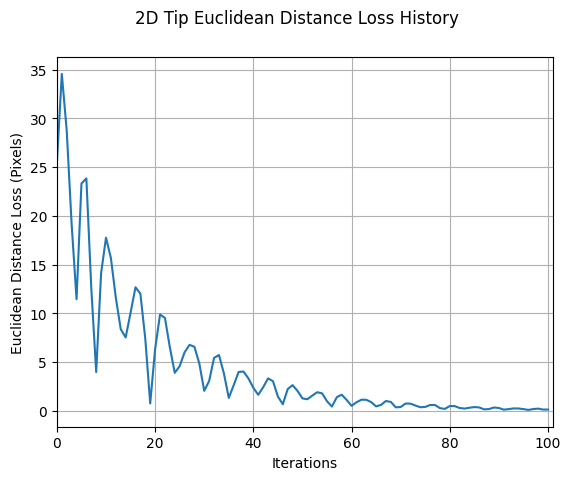

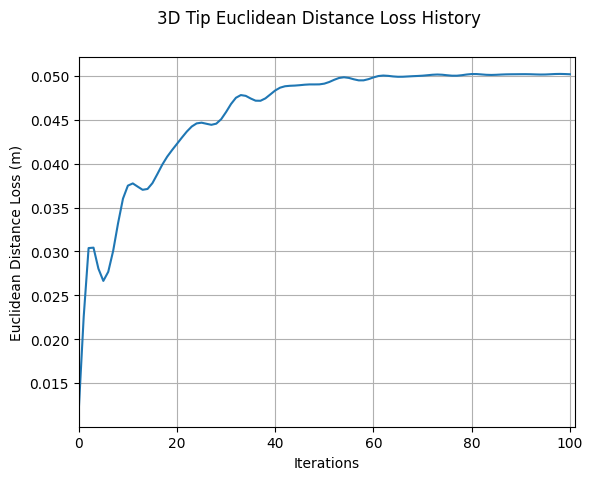

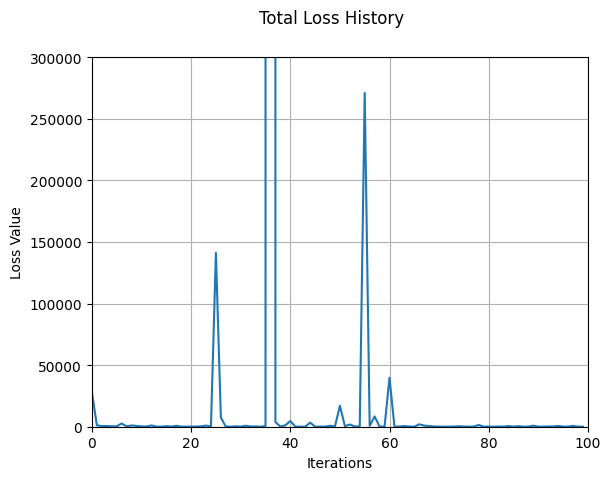

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:10,  1.32s/it, loss=1.56e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:09,  1.32s/it, loss=1.74e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:06,  1.31s/it, loss=1.16e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:07,  1.32s/it, loss=1.09e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:16,  1.43s/it, loss=387]    


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:13,  1.42s/it, loss=93.9]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:09,  1.39s/it, loss=458] 


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:02,  1.34s/it, loss=2.61e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:02,  1.35s/it, loss=1.9e+3] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:01,  1.35s/it, loss=440]  


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:58,  1.33s/it, loss=2.53e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<01:56,  1.33s/it, loss=173]    


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:58,  1.36s/it, loss=176]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:56,  1.35s/it, loss=330]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:54,  1.35s/it, loss=289]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:52,  1.34s/it, loss=257]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:50,  1.34s/it, loss=1.53e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:52,  1.37s/it, loss=284]    


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:50,  1.37s/it, loss=94.7]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:50,  1.38s/it, loss=777] 


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:49,  1.39s/it, loss=1.71e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:47,  1.37s/it, loss=250]    


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:46,  1.39s/it, loss=673]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:43,  1.36s/it, loss=110]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:42,  1.36s/it, loss=151]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:40,  1.36s/it, loss=3.73e+4]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:38,  1.34s/it, loss=6.75e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:36,  1.35s/it, loss=7.54e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:35,  1.35s/it, loss=94.3]   


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:34,  1.35s/it, loss=4.33e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:33,  1.36s/it, loss=306]    


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:31,  1.35s/it, loss=371]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:31,  1.37s/it, loss=315]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:28,  1.35s/it, loss=1.51e+3]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:28,  1.36s/it, loss=34.8]   


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:31,  1.43s/it, loss=1.94e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:28,  1.41s/it, loss=38.6]   


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:26,  1.40s/it, loss=444] 


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:23,  1.37s/it, loss=151]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:21,  1.36s/it, loss=84] 


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:20,  1.36s/it, loss=5.24e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:19,  1.36s/it, loss=197]    


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:16,  1.34s/it, loss=64] 


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:15,  1.34s/it, loss=41.4]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:14,  1.35s/it, loss=5.15e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:12,  1.34s/it, loss=40.7]   


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:03<01:11,  1.35s/it, loss=151] 


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:11,  1.37s/it, loss=1.21e+5]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:08,  1.35s/it, loss=2.69e+3]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:07<01:07,  1.35s/it, loss=2.29e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:05,  1.34s/it, loss=182]    


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:04,  1.34s/it, loss=2.06e+6]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:03,  1.35s/it, loss=16.2]   


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:13<01:03,  1.39s/it, loss=361] 


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:14<01:02,  1.38s/it, loss=706]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<01:00,  1.38s/it, loss=98.1]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:17<00:58,  1.35s/it, loss=89.9]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:18<00:57,  1.37s/it, loss=216] 


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:55,  1.35s/it, loss=76.9]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:21<00:53,  1.34s/it, loss=22.5]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:22<00:52,  1.35s/it, loss=46.6]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:24<00:51,  1.35s/it, loss=1.07e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:25<00:52,  1.42s/it, loss=101]    


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:27<00:49,  1.39s/it, loss=3.76e+3]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:48,  1.38s/it, loss=1.22e+4]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:29<00:46,  1.36s/it, loss=4.61e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:31<00:45,  1.37s/it, loss=23.4]   


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:32<00:44,  1.38s/it, loss=1.8e+3]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:34<00:42,  1.38s/it, loss=2.85e+4]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:41,  1.39s/it, loss=141]    


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:36<00:39,  1.37s/it, loss=1.08e+4]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:38<00:38,  1.37s/it, loss=8.73e+4]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:37,  1.37s/it, loss=819]    


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:40<00:35,  1.36s/it, loss=389]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:42<00:33,  1.35s/it, loss=88.1]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:43<00:31,  1.33s/it, loss=222] 


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:44<00:30,  1.34s/it, loss=18] 


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:29,  1.32s/it, loss=1.65e+6]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:47<00:27,  1.33s/it, loss=99.2]   


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:48<00:26,  1.34s/it, loss=2.35e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:50<00:25,  1.33s/it, loss=439]    


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:51<00:23,  1.32s/it, loss=1.84e+5]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:52<00:22,  1.32s/it, loss=4.34e+3]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:54<00:21,  1.34s/it, loss=120]    


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:55<00:20,  1.35s/it, loss=1.07e+3]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:56<00:19,  1.36s/it, loss=40.4]   


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:58<00:17,  1.34s/it, loss=3.17e+3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:59<00:16,  1.36s/it, loss=481]    


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:00<00:14,  1.34s/it, loss=40.8]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:02<00:13,  1.36s/it, loss=1.1e+3]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:03<00:12,  1.36s/it, loss=1.57e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:04<00:10,  1.35s/it, loss=314]    


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:06<00:09,  1.35s/it, loss=125]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:07<00:08,  1.35s/it, loss=1.86e+5]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:09<00:06,  1.35s/it, loss=43.6]   


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:10<00:05,  1.43s/it, loss=55.8]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:11<00:04,  1.40s/it, loss=88.6]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:13<00:02,  1.37s/it, loss=5.75e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:14<00:01,  1.37s/it, loss=1.44e+5]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:16<00:00,  1.36s/it, loss=78.7]  


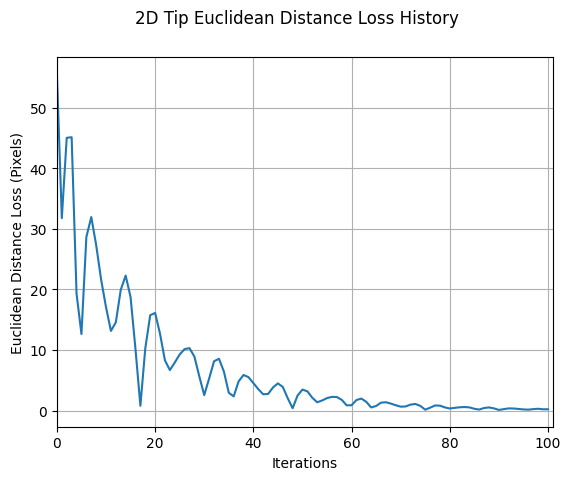

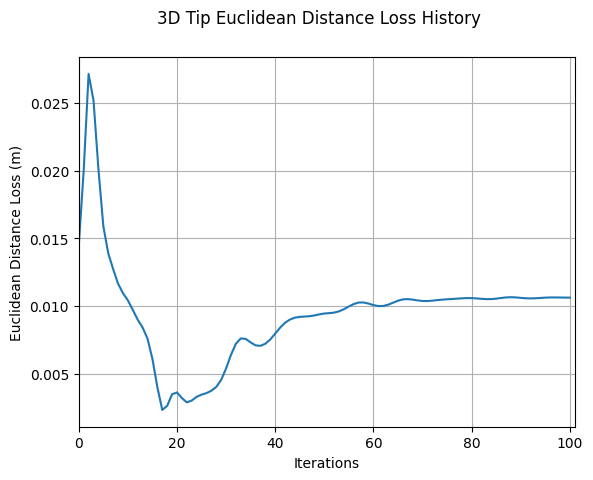

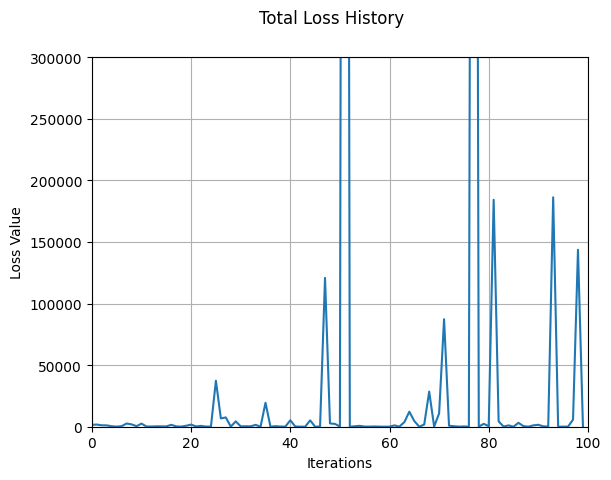

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:06,  1.28s/it, loss=2.15e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:07,  1.31s/it, loss=215]    


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:06,  1.31s/it, loss=1.23e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:05,  1.31s/it, loss=1.21e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:06,  1.34s/it, loss=559]    


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:03,  1.31s/it, loss=175]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:03,  1.33s/it, loss=2e+5]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:02,  1.33s/it, loss=586] 


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:59,  1.32s/it, loss=4.65e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:00,  1.34s/it, loss=603]   


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:57,  1.32s/it, loss=1.3e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:55,  1.32s/it, loss=145]   


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:57,  1.35s/it, loss=600]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:56,  1.35s/it, loss=270]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:19<01:55,  1.35s/it, loss=1.48e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:53,  1.35s/it, loss=238]    


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:52,  1.35s/it, loss=200]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:50,  1.35s/it, loss=756]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:50,  1.36s/it, loss=348]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:48,  1.36s/it, loss=65.4]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:47,  1.37s/it, loss=84.6]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:44,  1.34s/it, loss=500] 


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:30<01:44,  1.35s/it, loss=156]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:43,  1.36s/it, loss=729]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:40,  1.34s/it, loss=2.4e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:34<01:40,  1.36s/it, loss=1.66e+4]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:39,  1.36s/it, loss=46.6]   


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:37,  1.36s/it, loss=183] 


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:38<01:35,  1.35s/it, loss=6.5e+6]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:34,  1.35s/it, loss=114]   


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:41<01:32,  1.34s/it, loss=2.7e+3]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:42<01:31,  1.35s/it, loss=95]    


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:31,  1.36s/it, loss=134]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:45<01:29,  1.36s/it, loss=707]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:28,  1.36s/it, loss=1.37e+5]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:48<01:25,  1.34s/it, loss=166]    


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:49<01:27,  1.39s/it, loss=2.31e+4]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:25,  1.38s/it, loss=46.2]   


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:52<01:23,  1.37s/it, loss=187] 


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:53<01:22,  1.38s/it, loss=243]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:20,  1.36s/it, loss=45.9]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:56<01:18,  1.36s/it, loss=53.3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:18,  1.37s/it, loss=234] 


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:15,  1.34s/it, loss=149]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:00<01:14,  1.36s/it, loss=2.98e+4]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:13,  1.36s/it, loss=146]    


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:03<01:12,  1.37s/it, loss=4.42e+3]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:04<01:11,  1.37s/it, loss=3.09e+3]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:08,  1.35s/it, loss=99.6]   


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:07<01:07,  1.35s/it, loss=56.9]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:08<01:06,  1.36s/it, loss=169] 


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:05,  1.36s/it, loss=71.9]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:11<01:03,  1.36s/it, loss=7.31e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:12<01:02,  1.36s/it, loss=88]     


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:14<01:01,  1.36s/it, loss=67.1]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:15<01:00,  1.37s/it, loss=6.04e+3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:17<00:57,  1.34s/it, loss=2.61e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:18<00:57,  1.38s/it, loss=111]    


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:19<00:55,  1.35s/it, loss=33.1]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:21<00:54,  1.35s/it, loss=152] 


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:22<00:53,  1.37s/it, loss=199]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:23<00:52,  1.38s/it, loss=96.5]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:25<00:51,  1.40s/it, loss=9.17e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:27<00:53,  1.50s/it, loss=319]    


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:50,  1.45s/it, loss=464]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:29<00:48,  1.43s/it, loss=880]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:31<00:46,  1.41s/it, loss=38.7]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:32<00:44,  1.38s/it, loss=64.4]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:33<00:42,  1.38s/it, loss=99.7]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:40,  1.36s/it, loss=1.34e+3]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:36<00:40,  1.38s/it, loss=4.52e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:37<00:38,  1.37s/it, loss=3.19e+4]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:37,  1.37s/it, loss=190]    


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:40<00:34,  1.34s/it, loss=342]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:42<00:33,  1.35s/it, loss=170]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:43<00:32,  1.34s/it, loss=256]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:44<00:31,  1.36s/it, loss=31.6]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:29,  1.34s/it, loss=6.03e+6]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:47<00:28,  1.35s/it, loss=50.2]   


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:48<00:27,  1.36s/it, loss=926] 


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:50<00:25,  1.36s/it, loss=185]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:51<00:24,  1.34s/it, loss=47.7]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:52<00:22,  1.35s/it, loss=918] 


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:54<00:21,  1.34s/it, loss=5.21e+6]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:55<00:20,  1.35s/it, loss=31.2]   


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:56<00:18,  1.33s/it, loss=40.5]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:58<00:17,  1.35s/it, loss=42.5]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:59<00:16,  1.35s/it, loss=33.1]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:00<00:14,  1.34s/it, loss=34.9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:02<00:13,  1.33s/it, loss=132] 


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:03<00:12,  1.35s/it, loss=131]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:04<00:10,  1.35s/it, loss=1.5e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:06<00:09,  1.36s/it, loss=40.9]  


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:07<00:08,  1.35s/it, loss=7.18e+3]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:08<00:06,  1.33s/it, loss=1.27e+5]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:10<00:05,  1.35s/it, loss=98.8]   


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:11<00:04,  1.45s/it, loss=999] 


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:13<00:02,  1.43s/it, loss=85.8]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:14<00:01,  1.40s/it, loss=1.5e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:16<00:00,  1.36s/it, loss=283]  


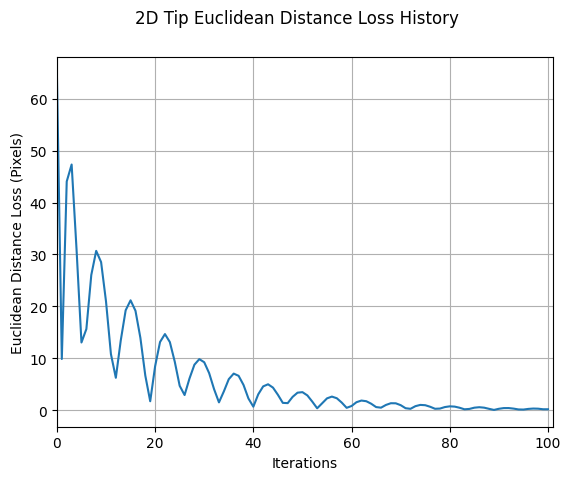

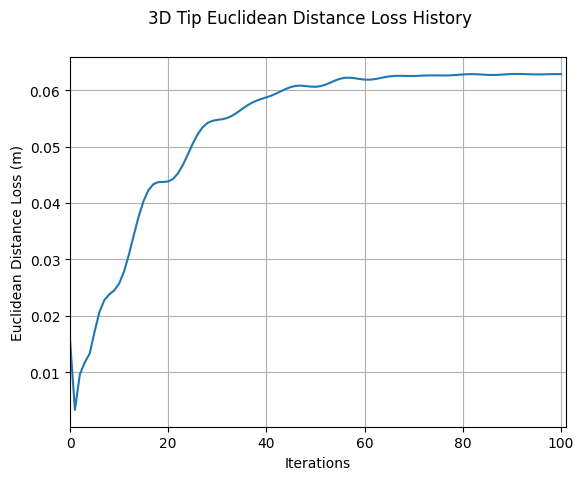

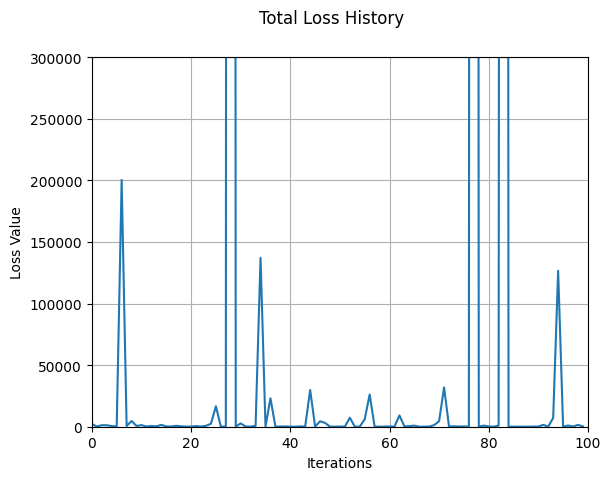

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:15,  1.36s/it, loss=3.95e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:08,  1.31s/it, loss=5.68e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:08,  1.33s/it, loss=2.73e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:08,  1.33s/it, loss=1.36e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:08,  1.36s/it, loss=1.94e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:06,  1.34s/it, loss=1.82e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:03,  1.32s/it, loss=879]    


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:04,  1.36s/it, loss=663]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:03,  1.36s/it, loss=302]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:00,  1.34s/it, loss=259]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<02:00,  1.36s/it, loss=474]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<02:00,  1.36s/it, loss=588]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:56,  1.34s/it, loss=1.1e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:56,  1.36s/it, loss=1.09e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:53,  1.33s/it, loss=423]    


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:53,  1.35s/it, loss=503]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:51,  1.34s/it, loss=952]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:49,  1.33s/it, loss=1.33e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:49,  1.35s/it, loss=1.41e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:44,  1.31s/it, loss=1.56e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:43,  1.31s/it, loss=307]    


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:44,  1.34s/it, loss=356]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:30<01:43,  1.34s/it, loss=422]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:42,  1.35s/it, loss=105]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:42,  1.36s/it, loss=1.63e+6]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:34<01:40,  1.36s/it, loss=42.8]   


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:40,  1.37s/it, loss=3.2e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:37,  1.36s/it, loss=2.83e+4]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:35,  1.34s/it, loss=128]    


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:33,  1.34s/it, loss=643]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:41<01:33,  1.35s/it, loss=1.33e+3]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:42<01:30,  1.33s/it, loss=1.35e+3]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:30,  1.35s/it, loss=567]    


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:45<01:29,  1.36s/it, loss=211]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:28,  1.35s/it, loss=617]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:48<01:23,  1.31s/it, loss=4.07e+3]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:49<01:23,  1.32s/it, loss=482]    


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:26,  1.39s/it, loss=85.9]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:52<01:24,  1.38s/it, loss=770] 


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:53<01:22,  1.38s/it, loss=162]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:21,  1.39s/it, loss=547]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:56<01:19,  1.38s/it, loss=102]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:18,  1.38s/it, loss=160]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:17,  1.38s/it, loss=884]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:00<01:15,  1.37s/it, loss=140]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:14,  1.38s/it, loss=202]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:03<01:10,  1.34s/it, loss=81.5]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:04<01:10,  1.35s/it, loss=92.5]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:08,  1.34s/it, loss=67.5]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:07<01:07,  1.35s/it, loss=349] 


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:08<01:06,  1.36s/it, loss=120]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:04,  1.34s/it, loss=2.02e+3]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:11<01:04,  1.37s/it, loss=84.2]   


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:13<01:03,  1.37s/it, loss=5.19e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:14<00:59,  1.33s/it, loss=542]    


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:15<01:00,  1.38s/it, loss=457]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:17<00:59,  1.39s/it, loss=188]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:18<00:57,  1.37s/it, loss=14.4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:19<00:56,  1.38s/it, loss=761] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:21<00:54,  1.37s/it, loss=8.15e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:22<00:53,  1.37s/it, loss=304]    


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:24<00:53,  1.40s/it, loss=2.19e+4]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:25<00:51,  1.38s/it, loss=47.7]   


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:26<00:51,  1.44s/it, loss=81.9]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:49,  1.42s/it, loss=66.3]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:29<00:47,  1.39s/it, loss=1.03e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:31<00:45,  1.39s/it, loss=178]    


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:32<00:44,  1.39s/it, loss=347]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:33<00:41,  1.35s/it, loss=116]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:40,  1.37s/it, loss=1.01e+5]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:36<00:39,  1.37s/it, loss=3.31e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:37<00:37,  1.35s/it, loss=61.5]   


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:36,  1.36s/it, loss=92.6]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:40<00:34,  1.34s/it, loss=7.43e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:41<00:33,  1.34s/it, loss=343]    


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:43<00:31,  1.33s/it, loss=55.6]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:44<00:30,  1.33s/it, loss=1.84e+3]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:45<00:29,  1.32s/it, loss=58.2]   


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:47<00:27,  1.33s/it, loss=16.1]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:48<00:26,  1.35s/it, loss=303] 


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:49<00:25,  1.36s/it, loss=24.8]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:51<00:24,  1.37s/it, loss=91.2]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:52<00:23,  1.35s/it, loss=497] 


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:54<00:21,  1.37s/it, loss=2.19e+3]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:55<00:20,  1.37s/it, loss=30.1]   


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:56<00:18,  1.34s/it, loss=41.8]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:58<00:17,  1.35s/it, loss=3.97e+3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:59<00:16,  1.35s/it, loss=50.7]   


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:00<00:15,  1.37s/it, loss=132] 


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:02<00:13,  1.35s/it, loss=11.8]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:03<00:12,  1.36s/it, loss=517] 


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:04<00:10,  1.36s/it, loss=989]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:06<00:09,  1.38s/it, loss=99.5]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:07<00:08,  1.38s/it, loss=76.9]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:08<00:06,  1.36s/it, loss=2.35e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:10<00:05,  1.36s/it, loss=524]    


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:11<00:04,  1.37s/it, loss=43.3]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:13<00:02,  1.45s/it, loss=231] 


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:14<00:01,  1.43s/it, loss=68.2]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:16<00:00,  1.36s/it, loss=50.9]


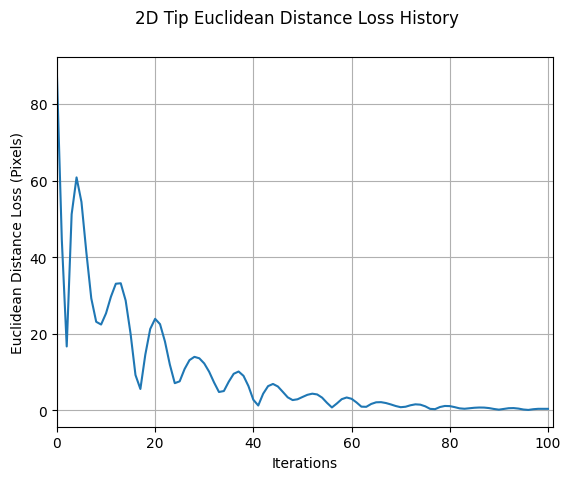

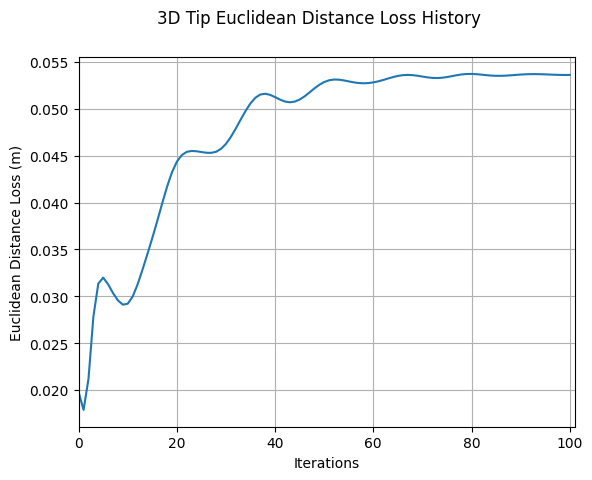

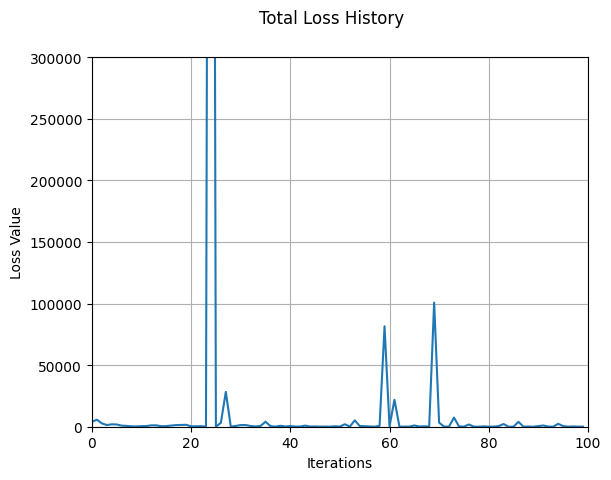

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:04,  1.26s/it, loss=6.59e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:10,  1.33s/it, loss=2.44e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:09,  1.34s/it, loss=346]    


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:13,  1.39s/it, loss=1.01e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:16,  1.43s/it, loss=1.93e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:10,  1.39s/it, loss=2.07e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:07,  1.37s/it, loss=1.21e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:06,  1.37s/it, loss=620]    


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:02,  1.35s/it, loss=381]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<01:58,  1.32s/it, loss=863]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:58,  1.34s/it, loss=544]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<01:56,  1.32s/it, loss=2.77e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:55,  1.33s/it, loss=4.39e+5]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:53,  1.33s/it, loss=3.76e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:52,  1.33s/it, loss=414]    


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:50,  1.32s/it, loss=302]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:50,  1.34s/it, loss=1.53e+4]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:48,  1.33s/it, loss=108]    


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:48,  1.34s/it, loss=137]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:48,  1.35s/it, loss=276]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:46,  1.34s/it, loss=388]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:44,  1.34s/it, loss=1.11e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:30<01:42,  1.34s/it, loss=251]    


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:41,  1.33s/it, loss=395]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:39,  1.33s/it, loss=4.14e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:34<01:40,  1.35s/it, loss=526]    


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:37,  1.34s/it, loss=48.6]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:37,  1.35s/it, loss=129] 


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:38<01:34,  1.34s/it, loss=664]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:32,  1.32s/it, loss=192]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:41<01:30,  1.31s/it, loss=771]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:42<01:31,  1.34s/it, loss=1.35e+3]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:30,  1.35s/it, loss=378]    


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:45<01:27,  1.33s/it, loss=528]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:46<01:24,  1.30s/it, loss=489]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:48<01:25,  1.33s/it, loss=129]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:49<01:22,  1.32s/it, loss=971]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:50<01:22,  1.33s/it, loss=63.2]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:52<01:25,  1.41s/it, loss=296] 


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:53<01:22,  1.37s/it, loss=242]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:19,  1.35s/it, loss=635]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:56<01:19,  1.37s/it, loss=65.7]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:57<01:16,  1.35s/it, loss=41.6]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:15,  1.36s/it, loss=101] 


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:00<01:14,  1.36s/it, loss=1.63e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:01<01:12,  1.34s/it, loss=4.16e+3]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:03<01:12,  1.37s/it, loss=376]    


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:04<01:09,  1.34s/it, loss=529]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:05<01:09,  1.36s/it, loss=49.6]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:07<01:08,  1.37s/it, loss=436] 


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:08<01:07,  1.37s/it, loss=222]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:06,  1.39s/it, loss=115]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:11<01:06,  1.41s/it, loss=904]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:12<01:04,  1.40s/it, loss=760]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:14<01:01,  1.37s/it, loss=8.7e+4]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:15<00:59,  1.36s/it, loss=6.01e+3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:16<00:58,  1.35s/it, loss=919]    


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:18<00:57,  1.36s/it, loss=11.5]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:19<00:55,  1.35s/it, loss=111] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:20<00:53,  1.34s/it, loss=1.78e+3]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:22<00:52,  1.35s/it, loss=136]    


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:23<00:51,  1.36s/it, loss=3.51e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:25<00:50,  1.36s/it, loss=1.14e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:26<00:48,  1.36s/it, loss=878]    


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:27<00:46,  1.34s/it, loss=1.17e+4]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:28<00:45,  1.32s/it, loss=609]    


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:30<00:46,  1.42s/it, loss=3.15e+4]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:31<00:44,  1.39s/it, loss=266]    


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:33<00:42,  1.37s/it, loss=18] 


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:34<00:40,  1.34s/it, loss=28.2]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:35<00:39,  1.35s/it, loss=1.11e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:37<00:38,  1.36s/it, loss=79.5]   


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:38<00:36,  1.35s/it, loss=101] 


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:39<00:35,  1.36s/it, loss=163]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:41<00:33,  1.35s/it, loss=784]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:42<00:32,  1.35s/it, loss=12.1]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:44<00:31,  1.36s/it, loss=544] 


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:45<00:30,  1.37s/it, loss=49.2]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:46<00:28,  1.37s/it, loss=1.2e+3]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:48<00:27,  1.35s/it, loss=271]   


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:49<00:25,  1.34s/it, loss=1.08e+4]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:50<00:24,  1.36s/it, loss=2.33e+4]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:52<00:22,  1.33s/it, loss=2.18e+3]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:53<00:21,  1.33s/it, loss=5.72e+3]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:54<00:19,  1.32s/it, loss=522]    


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:56<00:19,  1.36s/it, loss=51.5]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:57<00:17,  1.34s/it, loss=3.16e+3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:58<00:15,  1.32s/it, loss=173]    


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:00<00:14,  1.34s/it, loss=235]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:01<00:13,  1.33s/it, loss=465]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:02<00:11,  1.33s/it, loss=656]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:04<00:10,  1.33s/it, loss=13.8]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:05<00:09,  1.32s/it, loss=317] 


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:06<00:08,  1.35s/it, loss=51.6]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:08<00:06,  1.34s/it, loss=111] 


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:09<00:05,  1.36s/it, loss=227]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:10<00:04,  1.37s/it, loss=77.1]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:12<00:02,  1.37s/it, loss=1.49e+4]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:13<00:01,  1.39s/it, loss=204]    


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:15<00:00,  1.35s/it, loss=82.5]


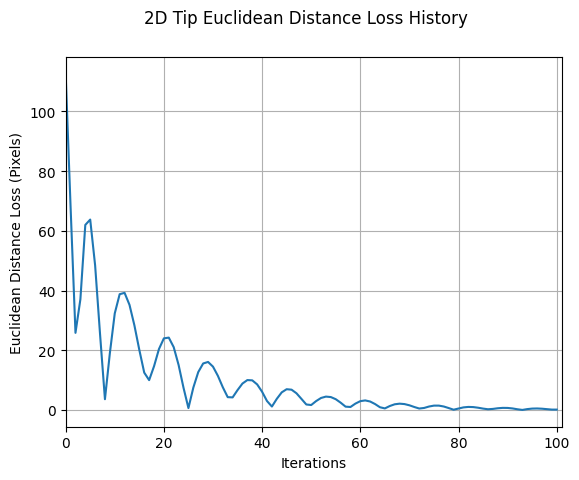

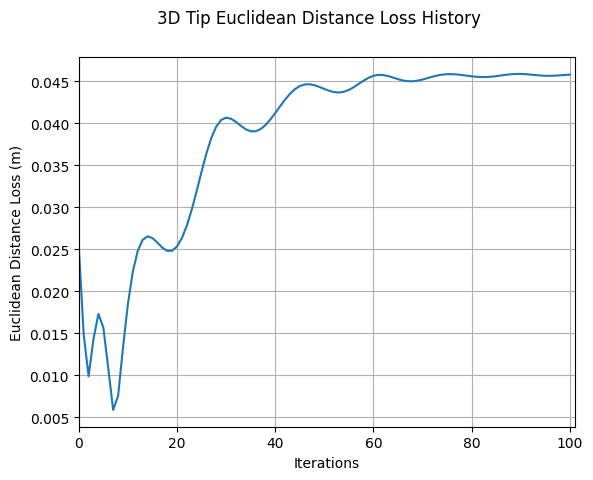

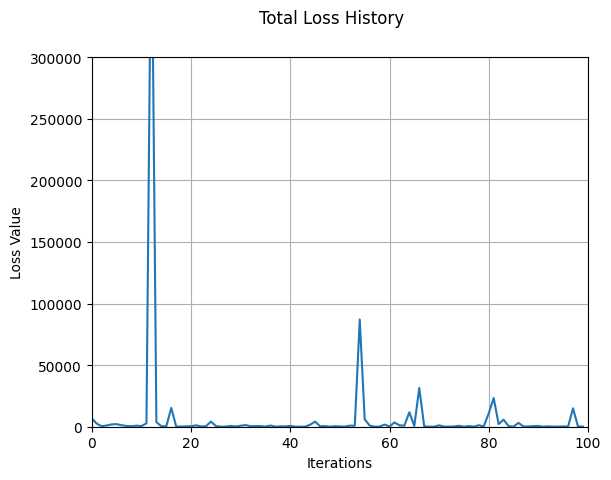

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:06,  1.27s/it, loss=5.82e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:06,  1.29s/it, loss=3.18e+4]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:10,  1.34s/it, loss=1.14e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:06,  1.32s/it, loss=808]    


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:04,  1.31s/it, loss=1.86e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:05,  1.33s/it, loss=2.86e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:05,  1.35s/it, loss=1.05e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:04,  1.35s/it, loss=592]    


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<02:01,  1.34s/it, loss=1.27e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:02,  1.36s/it, loss=293]   


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:59,  1.35s/it, loss=593]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<01:59,  1.36s/it, loss=829]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:56,  1.34s/it, loss=825]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:56,  1.35s/it, loss=775]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:55,  1.36s/it, loss=713]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:53,  1.36s/it, loss=1.09e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:53,  1.37s/it, loss=2.5e+3] 


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:52,  1.37s/it, loss=761]   


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:51,  1.38s/it, loss=363]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:50,  1.38s/it, loss=4.77e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:47,  1.36s/it, loss=2.07e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:43,  1.33s/it, loss=429]    


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:45,  1.36s/it, loss=287]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:42,  1.35s/it, loss=171]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:42,  1.36s/it, loss=3.62e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:41,  1.37s/it, loss=143]    


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:40,  1.38s/it, loss=354]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:39,  1.38s/it, loss=852]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:38,  1.38s/it, loss=192]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:37,  1.39s/it, loss=160]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:36,  1.39s/it, loss=6.09e+4]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:34,  1.39s/it, loss=56.4]   


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:33,  1.40s/it, loss=57.5]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:32,  1.40s/it, loss=146] 


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:29,  1.38s/it, loss=626]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:27,  1.37s/it, loss=3.96e+3]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:25,  1.36s/it, loss=341]    


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:25,  1.38s/it, loss=330]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:23,  1.37s/it, loss=1.59e+4]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:20,  1.35s/it, loss=438]    


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:20,  1.37s/it, loss=278]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:18,  1.35s/it, loss=111]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:21,  1.43s/it, loss=178]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:19,  1.43s/it, loss=110]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:17,  1.42s/it, loss=1.04e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:03<01:17,  1.43s/it, loss=202]    


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:15,  1.42s/it, loss=74.8]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:11,  1.38s/it, loss=260] 


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:07<01:10,  1.39s/it, loss=65.9]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:09,  1.39s/it, loss=1.96e+4]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:08,  1.40s/it, loss=298]    


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:11<01:06,  1.39s/it, loss=1.8e+4]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:04,  1.38s/it, loss=25.4]  


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:14<01:03,  1.39s/it, loss=112] 


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:01,  1.36s/it, loss=111]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<01:00,  1.39s/it, loss=1.34e+5]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:18<00:59,  1.38s/it, loss=2.05e+3]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:57,  1.36s/it, loss=30.5]   


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:56,  1.37s/it, loss=818] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:22<00:54,  1.37s/it, loss=1.34e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:23<00:53,  1.37s/it, loss=320]    


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:24<00:50,  1.32s/it, loss=75.1]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:26<00:49,  1.34s/it, loss=9.29e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:27<00:47,  1.33s/it, loss=1.14e+3]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:47,  1.35s/it, loss=9.65e+4]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:30<00:45,  1.34s/it, loss=139]    


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:31<00:43,  1.33s/it, loss=25.7]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:32<00:43,  1.36s/it, loss=6.53e+6]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:34<00:41,  1.33s/it, loss=6.64e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:40,  1.36s/it, loss=1.45e+5]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:37<00:40,  1.40s/it, loss=618]    


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:38<00:38,  1.37s/it, loss=1.77e+3]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:36,  1.36s/it, loss=704]    


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:41<00:35,  1.38s/it, loss=131]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:42<00:33,  1.36s/it, loss=277]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:43<00:32,  1.37s/it, loss=30.5]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:45<00:31,  1.37s/it, loss=39.6]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:29,  1.36s/it, loss=569] 


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:47<00:28,  1.35s/it, loss=341]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:49<00:26,  1.34s/it, loss=165]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:50<00:25,  1.34s/it, loss=76.3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:51<00:23,  1.33s/it, loss=627] 


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:53<00:22,  1.35s/it, loss=25.6]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:54<00:21,  1.35s/it, loss=110] 


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:55<00:20,  1.34s/it, loss=133]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:57<00:19,  1.36s/it, loss=13.8]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:58<00:17,  1.35s/it, loss=98]  


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:00<00:16,  1.37s/it, loss=526]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:01<00:14,  1.35s/it, loss=39.9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:02<00:13,  1.37s/it, loss=1.29e+3]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:04<00:12,  1.36s/it, loss=106]    


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:05<00:11,  1.39s/it, loss=189]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:07<00:09,  1.39s/it, loss=41.7]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:08<00:08,  1.40s/it, loss=149] 


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:09<00:07,  1.42s/it, loss=1.04e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:11<00:05,  1.38s/it, loss=92.3]   


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:12<00:04,  1.40s/it, loss=618] 


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:13<00:02,  1.35s/it, loss=463]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:15<00:01,  1.38s/it, loss=338]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:16<00:00,  1.37s/it, loss=1.95e+3]


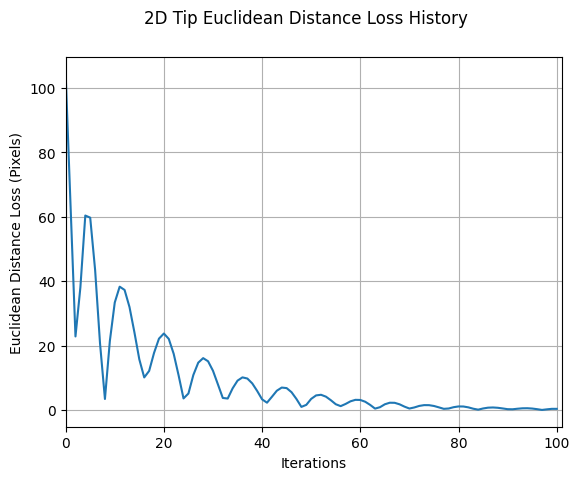

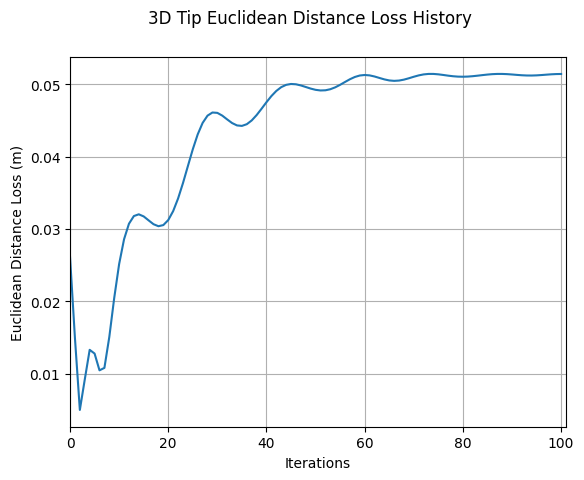

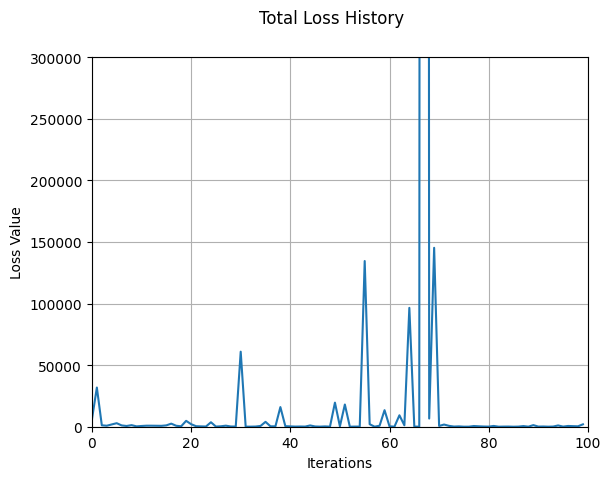

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:04,  1.26s/it, loss=7.86e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:12,  1.35s/it, loss=1.37e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:07,  1.32s/it, loss=627]    


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:05,  1.31s/it, loss=3.99e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:03,  1.30s/it, loss=2.84e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:07,  1.36s/it, loss=1.22e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:01,  1.31s/it, loss=117]    


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<01:59,  1.29s/it, loss=275]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:59,  1.31s/it, loss=744]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<01:58,  1.31s/it, loss=1.26e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:58,  1.33s/it, loss=1.35e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:57,  1.33s/it, loss=1.25e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:55,  1.33s/it, loss=546]    


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:56,  1.36s/it, loss=776]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:19<01:55,  1.36s/it, loss=821]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:53,  1.35s/it, loss=265]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:51,  1.34s/it, loss=523]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:23<01:49,  1.34s/it, loss=630]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:49,  1.36s/it, loss=3.35e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:46,  1.34s/it, loss=364]    


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:47,  1.36s/it, loss=94.2]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:45,  1.35s/it, loss=1.85e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:30<01:45,  1.37s/it, loss=121]    


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:46,  1.40s/it, loss=383]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:40,  1.35s/it, loss=356]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:34<01:41,  1.37s/it, loss=260]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:40,  1.38s/it, loss=435]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:37,  1.36s/it, loss=333]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:38<01:37,  1.37s/it, loss=996]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:34,  1.35s/it, loss=102]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:41<01:35,  1.38s/it, loss=126]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:42<01:30,  1.34s/it, loss=117]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:30,  1.36s/it, loss=257]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:45<01:29,  1.36s/it, loss=127]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:27,  1.35s/it, loss=1.53e+3]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:48<01:27,  1.36s/it, loss=586]    


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:49<01:23,  1.33s/it, loss=31.2]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:24,  1.36s/it, loss=174] 


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:52<01:24,  1.39s/it, loss=3.9e+3]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:23,  1.40s/it, loss=216]   


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:23,  1.41s/it, loss=459]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:56<01:21,  1.40s/it, loss=134]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:18,  1.38s/it, loss=108]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:17,  1.39s/it, loss=2.53e+4]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:00<01:16,  1.39s/it, loss=260]    


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:13,  1.37s/it, loss=266]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:03<01:10,  1.34s/it, loss=197]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:12,  1.40s/it, loss=118]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:11,  1.40s/it, loss=1.7e+3]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:07<01:08,  1.37s/it, loss=1.86e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:07,  1.38s/it, loss=25.8]   


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:06,  1.39s/it, loss=124] 


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:11<01:04,  1.38s/it, loss=1.2e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:13<01:02,  1.36s/it, loss=129]   


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:14<01:02,  1.39s/it, loss=2.76e+3]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<01:00,  1.37s/it, loss=37]     


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:17<00:59,  1.37s/it, loss=1.84e+3]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:18<00:57,  1.36s/it, loss=1.23e+4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:56,  1.39s/it, loss=39.8]   


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:21<00:54,  1.36s/it, loss=4.76e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:22<00:53,  1.37s/it, loss=28]     


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:24<00:51,  1.35s/it, loss=759]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:25<00:50,  1.37s/it, loss=147]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:26<00:48,  1.36s/it, loss=699]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:46,  1.34s/it, loss=95.9]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:29<00:46,  1.37s/it, loss=3.04e+4]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:30<00:44,  1.34s/it, loss=103]    


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:32<00:42,  1.34s/it, loss=144]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:33<00:41,  1.32s/it, loss=3.05e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:34<00:40,  1.34s/it, loss=50.3]   


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:36<00:39,  1.36s/it, loss=227] 


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:37<00:37,  1.34s/it, loss=92.8]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:36,  1.36s/it, loss=410] 


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:40<00:34,  1.34s/it, loss=2.62e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:41<00:34,  1.36s/it, loss=165]    


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:43<00:32,  1.34s/it, loss=182]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:44<00:30,  1.34s/it, loss=36.9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:31,  1.45s/it, loss=2.11e+4]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:47<00:29,  1.40s/it, loss=152]    


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:48<00:27,  1.38s/it, loss=1.66e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:50<00:26,  1.37s/it, loss=7.32e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:51<00:24,  1.35s/it, loss=3.36e+3]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:52<00:22,  1.34s/it, loss=6.05e+4]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:54<00:21,  1.37s/it, loss=719]    


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:55<00:20,  1.38s/it, loss=3.32e+3]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:56<00:19,  1.37s/it, loss=271]    


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:58<00:17,  1.38s/it, loss=36.3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:59<00:16,  1.39s/it, loss=69.4]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:01<00:15,  1.40s/it, loss=506] 


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:02<00:14,  1.41s/it, loss=355]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:04<00:12,  1.42s/it, loss=75.8]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:05<00:11,  1.38s/it, loss=1.38e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:06<00:09,  1.39s/it, loss=226]    


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:08<00:08,  1.36s/it, loss=335]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:09<00:06,  1.39s/it, loss=103]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:10<00:05,  1.37s/it, loss=142]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:12<00:04,  1.40s/it, loss=610]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:13<00:02,  1.38s/it, loss=1.33e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:14<00:01,  1.38s/it, loss=4.61e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:16<00:00,  1.36s/it, loss=3.93e+3]


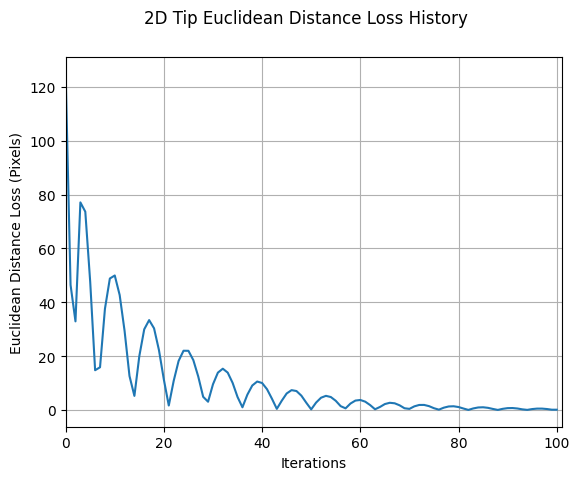

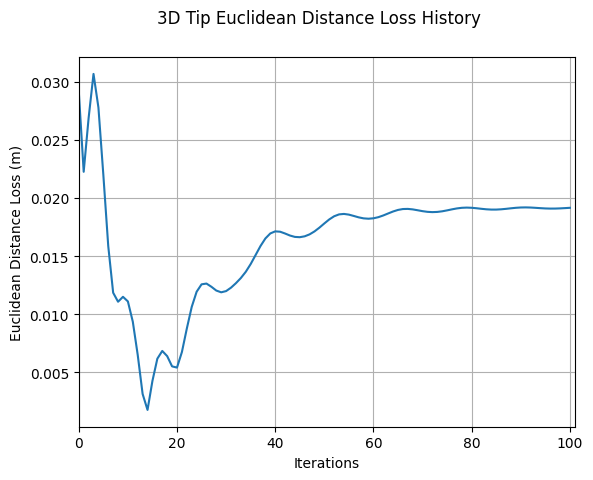

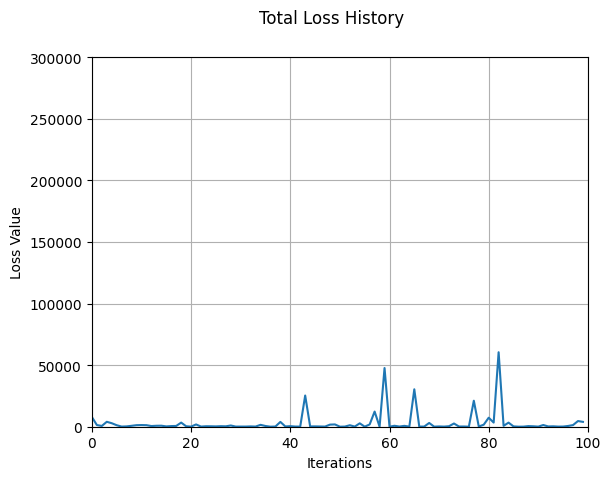

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:04,  1.26s/it, loss=2.22e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:06,  1.29s/it, loss=6.34e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:10,  1.34s/it, loss=1.37e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:08,  1.34s/it, loss=5.08e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:07,  1.34s/it, loss=484]    


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:06,  1.34s/it, loss=5.53e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:07,  1.38s/it, loss=301]    


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:06,  1.38s/it, loss=491]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:06,  1.39s/it, loss=546]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:06,  1.40s/it, loss=1.95e+4]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:15<02:05,  1.41s/it, loss=4.83e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<02:03,  1.40s/it, loss=2.42e+4]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:18<02:07,  1.46s/it, loss=766]    


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:19<02:05,  1.46s/it, loss=187]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:21<02:07,  1.50s/it, loss=333]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:22<02:09,  1.54s/it, loss=4.86e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:24<02:04,  1.50s/it, loss=1.16e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:25<01:59,  1.45s/it, loss=90.1]   


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:26<01:56,  1.44s/it, loss=228] 


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:28<01:52,  1.41s/it, loss=664]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:29<01:51,  1.41s/it, loss=206]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:31<01:50,  1.41s/it, loss=221]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:32<01:49,  1.42s/it, loss=354]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:33<01:47,  1.42s/it, loss=946]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:35<01:43,  1.39s/it, loss=71.9]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:36<01:42,  1.38s/it, loss=62.6]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:38<01:41,  1.39s/it, loss=161] 


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:39<01:40,  1.39s/it, loss=61.6]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:40<01:39,  1.40s/it, loss=441] 


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:42<01:38,  1.40s/it, loss=83.9]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:43<01:37,  1.41s/it, loss=107] 


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:45<01:35,  1.41s/it, loss=53.2]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:46<01:35,  1.43s/it, loss=225] 


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:47<01:34,  1.42s/it, loss=236]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:49<01:38,  1.52s/it, loss=1.97e+3]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:51<01:35,  1.48s/it, loss=171]    


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:52<01:32,  1.46s/it, loss=76.5]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:53<01:28,  1.43s/it, loss=40.7]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:55<01:27,  1.43s/it, loss=112] 


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:56<01:25,  1.42s/it, loss=2.26e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:58<01:23,  1.42s/it, loss=156]    


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:59<01:22,  1.42s/it, loss=598]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [01:00<01:21,  1.42s/it, loss=37] 


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:02<01:18,  1.41s/it, loss=62.4]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:03<01:18,  1.43s/it, loss=70.4]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:05<01:16,  1.42s/it, loss=30]  


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:06<01:15,  1.42s/it, loss=68.3]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:08<01:13,  1.42s/it, loss=5.9e+4]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:09<01:11,  1.39s/it, loss=250]   


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:10<01:09,  1.39s/it, loss=262]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:12<01:08,  1.40s/it, loss=25.7]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:13<01:07,  1.40s/it, loss=28]  


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:14<01:04,  1.37s/it, loss=661]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:16<01:03,  1.39s/it, loss=130]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:17<01:01,  1.37s/it, loss=1.99e+3]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:19<01:01,  1.39s/it, loss=115]    


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:20<01:00,  1.40s/it, loss=78.7]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:21<00:57,  1.38s/it, loss=389] 


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:23<00:56,  1.39s/it, loss=281]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:24<00:54,  1.36s/it, loss=2.04e+3]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:26<00:56,  1.45s/it, loss=1.04e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:27<00:53,  1.41s/it, loss=50.1]   


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:28<00:51,  1.38s/it, loss=5.21e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:30<00:49,  1.37s/it, loss=23.4]   


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:31<00:48,  1.38s/it, loss=115] 


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:32<00:46,  1.36s/it, loss=491]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:34<00:45,  1.37s/it, loss=2.46e+6]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:35<00:43,  1.36s/it, loss=517]    


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:36<00:42,  1.36s/it, loss=9.02e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:38<00:41,  1.38s/it, loss=57]     


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:39<00:39,  1.36s/it, loss=58.9]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:41<00:38,  1.36s/it, loss=1.08e+3]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:42<00:36,  1.37s/it, loss=56.2]   


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:43<00:35,  1.38s/it, loss=55.6]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:45<00:34,  1.37s/it, loss=88.5]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:46<00:33,  1.38s/it, loss=5.28e+3]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:47<00:31,  1.37s/it, loss=129]    


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:49<00:29,  1.35s/it, loss=38.2]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:50<00:28,  1.37s/it, loss=127] 


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:52<00:27,  1.39s/it, loss=65.3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:53<00:26,  1.39s/it, loss=86]  


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:54<00:24,  1.38s/it, loss=70.2]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:56<00:23,  1.39s/it, loss=72]  


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:57<00:21,  1.36s/it, loss=45]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:58<00:20,  1.38s/it, loss=282]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [02:00<00:19,  1.39s/it, loss=67.3]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [02:01<00:18,  1.39s/it, loss=130] 


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:03<00:16,  1.35s/it, loss=25.8]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:04<00:14,  1.35s/it, loss=102] 


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:05<00:13,  1.34s/it, loss=7.98e+4]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:07<00:12,  1.36s/it, loss=103]    


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:08<00:10,  1.37s/it, loss=95.6]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:09<00:09,  1.38s/it, loss=881] 


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:11<00:08,  1.39s/it, loss=201]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:12<00:07,  1.47s/it, loss=239]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:14<00:05,  1.42s/it, loss=33.9]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:15<00:04,  1.42s/it, loss=584] 


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:16<00:02,  1.38s/it, loss=103]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:18<00:01,  1.40s/it, loss=334]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it, loss=21.6]


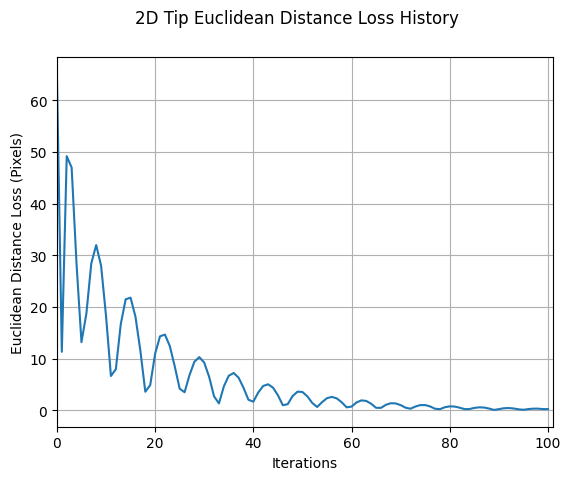

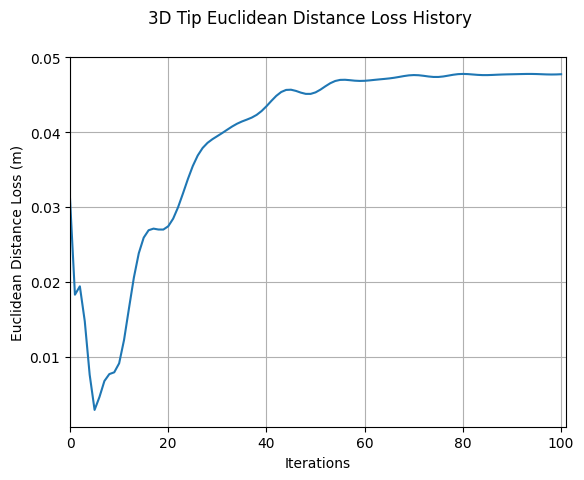

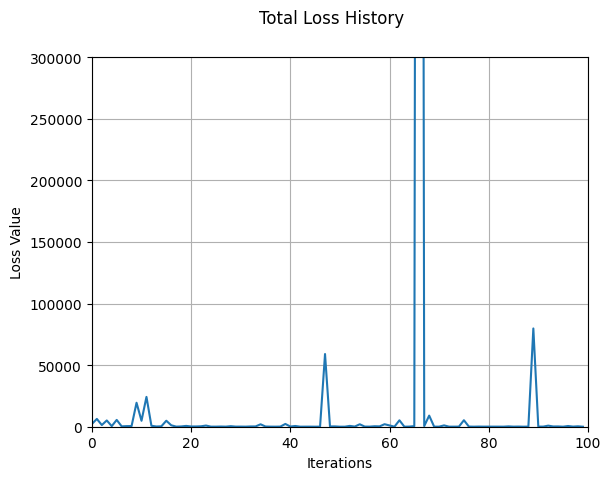

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:02,  1.23s/it, loss=7.02e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:06,  1.29s/it, loss=2e+3]   


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:11,  1.35s/it, loss=1.16e+4]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:22,  1.48s/it, loss=890]    


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:13,  1.40s/it, loss=1.46e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:09,  1.38s/it, loss=1.98e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:07,  1.37s/it, loss=2.02e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:05,  1.36s/it, loss=1.64e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:02,  1.34s/it, loss=1.2e+3] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:01,  1.35s/it, loss=620]  


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:59,  1.34s/it, loss=592]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<01:59,  1.36s/it, loss=6.04e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:55,  1.33s/it, loss=781]    


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:19<01:55,  1.35s/it, loss=956]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:52,  1.33s/it, loss=862]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:49,  1.30s/it, loss=817]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:48,  1.31s/it, loss=2.04e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:47,  1.31s/it, loss=598]    


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:46,  1.31s/it, loss=568]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:46,  1.33s/it, loss=130]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:44,  1.32s/it, loss=5.57e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:45,  1.35s/it, loss=51.6]   


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:30<01:43,  1.34s/it, loss=835] 


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:43,  1.36s/it, loss=327]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:42,  1.37s/it, loss=424]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:41,  1.37s/it, loss=271]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:41,  1.40s/it, loss=488]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:40,  1.40s/it, loss=390]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:39,  1.40s/it, loss=230]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:36,  1.38s/it, loss=75.5]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:35,  1.38s/it, loss=59]  


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:33,  1.38s/it, loss=51.1]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:32,  1.37s/it, loss=124] 


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:30,  1.37s/it, loss=122]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:29,  1.38s/it, loss=463]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:31,  1.43s/it, loss=179]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:27,  1.39s/it, loss=2.91e+5]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:27,  1.40s/it, loss=257]    


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:23,  1.37s/it, loss=145]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:23,  1.39s/it, loss=69.1]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:20,  1.37s/it, loss=88.8]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:19,  1.38s/it, loss=632] 


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:18,  1.37s/it, loss=384]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:16,  1.37s/it, loss=141]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:15,  1.37s/it, loss=81.9]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:12,  1.35s/it, loss=157] 


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:12,  1.36s/it, loss=770]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:10,  1.36s/it, loss=230]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:09,  1.37s/it, loss=28] 


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:09,  1.38s/it, loss=8.94e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:06,  1.36s/it, loss=53.6]   


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:05,  1.37s/it, loss=346] 


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:04,  1.37s/it, loss=1.92e+4]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:13<01:02,  1.37s/it, loss=1.06e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:01,  1.38s/it, loss=32.6]   


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<01:00,  1.37s/it, loss=21.2]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:17<00:59,  1.38s/it, loss=27.9]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:56,  1.35s/it, loss=535] 


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:55,  1.37s/it, loss=52.9]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:21<00:54,  1.35s/it, loss=74.4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:23<00:52,  1.36s/it, loss=1.68e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:24<00:54,  1.43s/it, loss=34.2]   


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:26<00:52,  1.41s/it, loss=53.8]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:27<00:51,  1.42s/it, loss=45.9]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:48,  1.38s/it, loss=184] 


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:30<00:47,  1.39s/it, loss=320]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:31<00:45,  1.37s/it, loss=3.65e+3]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:33<00:44,  1.39s/it, loss=695]    


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:34<00:42,  1.36s/it, loss=1.28e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:41,  1.38s/it, loss=183]    


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:37<00:39,  1.37s/it, loss=1.37e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:38<00:38,  1.39s/it, loss=63.5]   


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:37,  1.38s/it, loss=759] 


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:41<00:36,  1.40s/it, loss=4.46e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:42<00:35,  1.40s/it, loss=5.3e+5] 


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:44<00:33,  1.42s/it, loss=35.4]  


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:45<00:31,  1.39s/it, loss=359] 


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:30,  1.41s/it, loss=5.45e+5]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:48<00:29,  1.40s/it, loss=110]    


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:49<00:27,  1.38s/it, loss=106]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:51<00:25,  1.36s/it, loss=1.61e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:52<00:24,  1.38s/it, loss=345]    


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:53<00:23,  1.37s/it, loss=94] 


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:55<00:21,  1.35s/it, loss=25.7]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:56<00:20,  1.35s/it, loss=1.62e+4]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:57<00:18,  1.35s/it, loss=138]    


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:59<00:17,  1.35s/it, loss=109]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:00<00:16,  1.37s/it, loss=208]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:01<00:14,  1.35s/it, loss=96.6]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:03<00:13,  1.37s/it, loss=23.7]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:04<00:12,  1.35s/it, loss=166] 


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:05<00:10,  1.35s/it, loss=1.84e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:07<00:09,  1.37s/it, loss=819]    


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:08<00:08,  1.35s/it, loss=130]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:10<00:06,  1.37s/it, loss=76.2]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:11<00:05,  1.44s/it, loss=1.04e+3]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:13<00:04,  1.42s/it, loss=45.9]   


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:14<00:02,  1.38s/it, loss=418] 


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:15<00:01,  1.39s/it, loss=2.05e+4]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it, loss=27.2]  


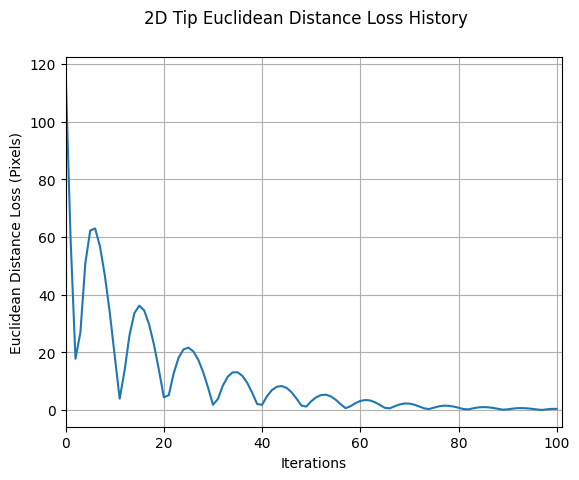

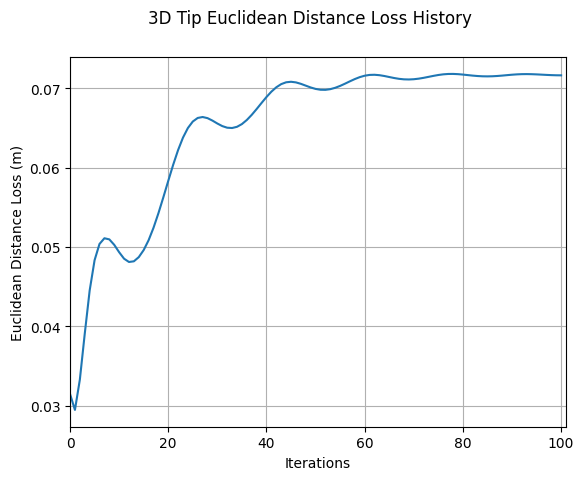

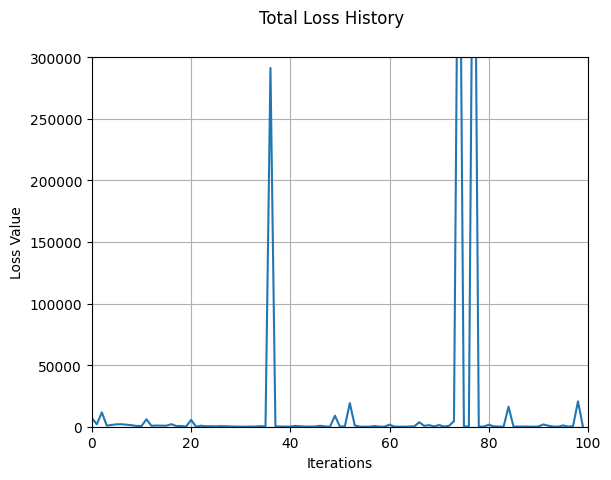

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:03,  1.24s/it, loss=121]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:04,  1.28s/it, loss=3.89e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:05,  1.29s/it, loss=234]    


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:04,  1.30s/it, loss=748]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:04,  1.31s/it, loss=2.06e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:04,  1.33s/it, loss=1.75e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:06,  1.36s/it, loss=3.44e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:06,  1.38s/it, loss=2.66e+6]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<02:02,  1.35s/it, loss=237]    


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:03,  1.37s/it, loss=1.43e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:59,  1.35s/it, loss=1.11e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<02:00,  1.37s/it, loss=912]    


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:56,  1.34s/it, loss=746]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:54,  1.33s/it, loss=432]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:54,  1.35s/it, loss=205]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:53,  1.36s/it, loss=877]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:51,  1.35s/it, loss=740]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:51,  1.37s/it, loss=999]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:52,  1.39s/it, loss=1.54e+4]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:51,  1.39s/it, loss=358]    


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:49,  1.38s/it, loss=96.9]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:51,  1.43s/it, loss=225] 


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:46,  1.39s/it, loss=267]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:45,  1.39s/it, loss=280]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:44,  1.40s/it, loss=573]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:43,  1.40s/it, loss=914]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:39,  1.37s/it, loss=2.71e+5]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:37,  1.36s/it, loss=1.31e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:35,  1.35s/it, loss=158]    


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:34,  1.34s/it, loss=1.42e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:31,  1.33s/it, loss=118]    


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:32,  1.36s/it, loss=5.78e+3]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:30,  1.36s/it, loss=256]    


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:30,  1.37s/it, loss=531]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:31,  1.41s/it, loss=1.63e+3]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:30,  1.42s/it, loss=460]    


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:26,  1.38s/it, loss=93.5]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:26,  1.39s/it, loss=31.2]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:24,  1.39s/it, loss=32.6]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:23,  1.39s/it, loss=2.58e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:20,  1.36s/it, loss=1.46e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:21,  1.40s/it, loss=2.67e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:17,  1.36s/it, loss=613]    


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:17,  1.39s/it, loss=78] 


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:15,  1.37s/it, loss=19.4]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:13,  1.36s/it, loss=90.7]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:11,  1.35s/it, loss=206] 


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:10,  1.37s/it, loss=2.93e+5]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:09,  1.36s/it, loss=2.09e+4]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:07,  1.34s/it, loss=272]    


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:06,  1.36s/it, loss=26.7]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:04,  1.34s/it, loss=96.9]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:04,  1.36s/it, loss=576] 


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:13<01:02,  1.35s/it, loss=1.19e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:01,  1.37s/it, loss=450]    


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<00:59,  1.35s/it, loss=78.2]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:17<00:57,  1.34s/it, loss=100] 


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:57,  1.36s/it, loss=584]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:55,  1.35s/it, loss=738]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:21<00:54,  1.36s/it, loss=1.25e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:23<00:52,  1.34s/it, loss=74.4]   


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:24<00:54,  1.43s/it, loss=228] 


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:26<00:52,  1.43s/it, loss=5.8e+6]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:27<00:50,  1.40s/it, loss=75.3]  


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:48,  1.38s/it, loss=285] 


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:30<00:46,  1.37s/it, loss=2.08e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:31<00:46,  1.41s/it, loss=47.4]   


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:33<00:45,  1.41s/it, loss=78.8]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:34<00:43,  1.41s/it, loss=438] 


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:35<00:41,  1.39s/it, loss=110]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:37<00:39,  1.38s/it, loss=1.14e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:38<00:39,  1.40s/it, loss=340]    


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:39<00:36,  1.36s/it, loss=22.4]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:41<00:36,  1.39s/it, loss=18.6]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:42<00:34,  1.37s/it, loss=31.9]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:44<00:32,  1.37s/it, loss=379] 


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:45<00:31,  1.38s/it, loss=6.13e+3]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:46<00:30,  1.39s/it, loss=3.75e+3]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:48<00:28,  1.37s/it, loss=38.2]   


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:49<00:27,  1.36s/it, loss=1.5e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:50<00:26,  1.37s/it, loss=16.7]  


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:52<00:24,  1.35s/it, loss=1.42e+8]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:53<00:23,  1.36s/it, loss=329]    


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:54<00:21,  1.35s/it, loss=618]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:56<00:20,  1.35s/it, loss=3.83e+3]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:57<00:18,  1.34s/it, loss=1.11e+3]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:58<00:17,  1.34s/it, loss=1.4e+3] 


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:00<00:16,  1.36s/it, loss=931]   


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:01<00:14,  1.34s/it, loss=34.9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:03<00:13,  1.36s/it, loss=252] 


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:04<00:12,  1.34s/it, loss=4.51e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:05<00:10,  1.34s/it, loss=1.31e+4]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:06<00:09,  1.34s/it, loss=8.78]   


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:08<00:08,  1.34s/it, loss=9.51e+4]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:09<00:07,  1.43s/it, loss=41.7]   


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:11<00:05,  1.40s/it, loss=19.2]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:12<00:04,  1.37s/it, loss=1.03e+3]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:14<00:02,  1.40s/it, loss=158]    


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:15<00:01,  1.37s/it, loss=202]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:16<00:00,  1.37s/it, loss=38.1]


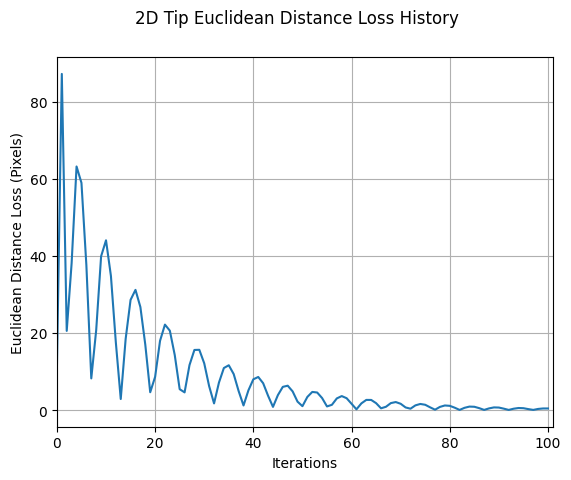

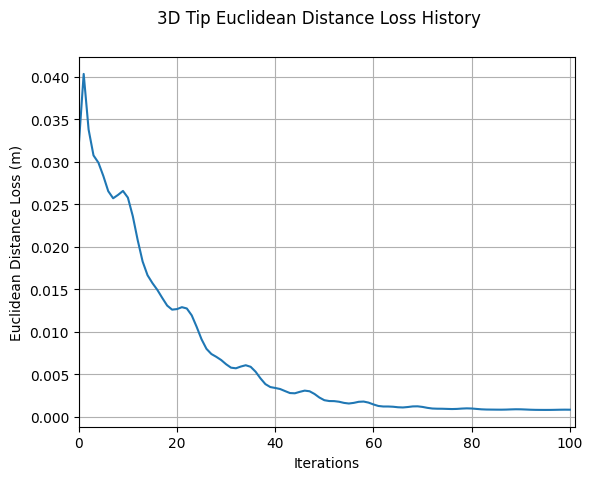

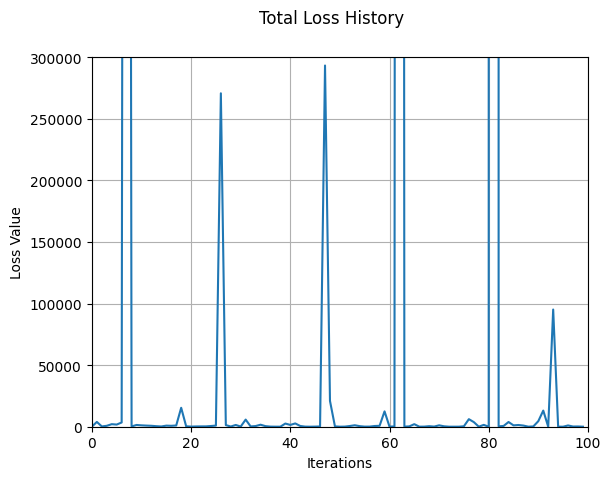

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:03,  1.25s/it, loss=1.47e+4]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:11,  1.34s/it, loss=1.46e+4]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:07,  1.32s/it, loss=5.54e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:06,  1.32s/it, loss=1.19e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:06,  1.34s/it, loss=2.23e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:07,  1.35s/it, loss=2.49e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:07,  1.37s/it, loss=3.02e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:03,  1.34s/it, loss=8.9e+3] 


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:04,  1.36s/it, loss=3.1e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:01,  1.35s/it, loss=2.93e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<02:01,  1.36s/it, loss=2.35e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<02:01,  1.38s/it, loss=1.09e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<02:01,  1.39s/it, loss=2.96e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:19<02:00,  1.40s/it, loss=912]    


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<02:00,  1.41s/it, loss=97.1]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:56,  1.39s/it, loss=312] 


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:23<01:56,  1.40s/it, loss=2.06e+5]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:53,  1.38s/it, loss=824]    


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:51,  1.38s/it, loss=1.24e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:48,  1.36s/it, loss=910]    


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:46,  1.34s/it, loss=934]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:42,  1.32s/it, loss=1.44e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:44,  1.35s/it, loss=779]    


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:41,  1.34s/it, loss=187]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:43,  1.38s/it, loss=586]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:40,  1.36s/it, loss=322]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:40,  1.38s/it, loss=1.27e+4]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:37,  1.35s/it, loss=3.71e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:35,  1.35s/it, loss=247]    


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:36,  1.37s/it, loss=760]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:34,  1.36s/it, loss=309]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:32,  1.36s/it, loss=3.31e+3]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:31,  1.37s/it, loss=6.92e+3]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:31,  1.38s/it, loss=166]    


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:34,  1.46s/it, loss=486]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:31,  1.43s/it, loss=817]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:30,  1.43s/it, loss=783]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:52<01:26,  1.40s/it, loss=45] 


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:23,  1.37s/it, loss=2.3e+7]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:23,  1.38s/it, loss=104]   


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:56<01:21,  1.39s/it, loss=136]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:18,  1.36s/it, loss=102]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:18,  1.38s/it, loss=3.3e+3]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:17,  1.39s/it, loss=909]   


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:17,  1.40s/it, loss=87.2]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:03<01:14,  1.38s/it, loss=496] 


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:14,  1.40s/it, loss=53.4]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:06<01:13,  1.42s/it, loss=594] 


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:07<01:09,  1.37s/it, loss=65.4]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:09,  1.39s/it, loss=785] 


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:10<01:07,  1.37s/it, loss=1.21e+4]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:11<01:07,  1.41s/it, loss=107]    


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:05,  1.39s/it, loss=336]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:14<01:04,  1.39s/it, loss=182]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:02,  1.38s/it, loss=903]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<01:00,  1.37s/it, loss=154]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:18<00:59,  1.39s/it, loss=629]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:57,  1.37s/it, loss=1.77e+3]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:21<00:56,  1.39s/it, loss=36.4]   


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:22<00:55,  1.40s/it, loss=77.2]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:24<00:56,  1.45s/it, loss=63]  


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:25<00:54,  1.44s/it, loss=104]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:27<00:53,  1.44s/it, loss=2.21e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:28<00:51,  1.43s/it, loss=412]    


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:29<00:49,  1.42s/it, loss=28.5]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:31<00:47,  1.39s/it, loss=128] 


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:32<00:46,  1.41s/it, loss=551]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:33<00:44,  1.38s/it, loss=1.12e+3]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:35<00:43,  1.39s/it, loss=293]    


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:36<00:41,  1.40s/it, loss=593]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:38<00:39,  1.37s/it, loss=81.8]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:39<00:39,  1.40s/it, loss=5.83e+3]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:40<00:37,  1.38s/it, loss=3.79e+4]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:42<00:35,  1.37s/it, loss=1.37e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:43<00:34,  1.39s/it, loss=1.12e+4]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:44<00:33,  1.38s/it, loss=28.1]   


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:46<00:31,  1.39s/it, loss=221] 


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:47<00:30,  1.37s/it, loss=340]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:49<00:29,  1.38s/it, loss=205]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:50<00:27,  1.36s/it, loss=725]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:51<00:26,  1.38s/it, loss=647]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:53<00:24,  1.38s/it, loss=1.1e+4]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:54<00:23,  1.37s/it, loss=9.8e+5]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:55<00:21,  1.35s/it, loss=64.8]  


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:57<00:20,  1.36s/it, loss=232] 


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:58<00:18,  1.35s/it, loss=29.3]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [02:00<00:17,  1.37s/it, loss=97.9]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:01<00:16,  1.36s/it, loss=3.19e+3]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:02<00:14,  1.36s/it, loss=929]    


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:04<00:13,  1.36s/it, loss=306]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:05<00:12,  1.36s/it, loss=154]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:06<00:11,  1.38s/it, loss=166]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:08<00:09,  1.36s/it, loss=1.56e+3]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:09<00:08,  1.36s/it, loss=114]    


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:11<00:07,  1.45s/it, loss=3.77e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:12<00:05,  1.43s/it, loss=26.8]   


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:13<00:04,  1.42s/it, loss=18.3]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:15<00:02,  1.39s/it, loss=329] 


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:16<00:01,  1.40s/it, loss=21.5]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:17<00:00,  1.38s/it, loss=50] 


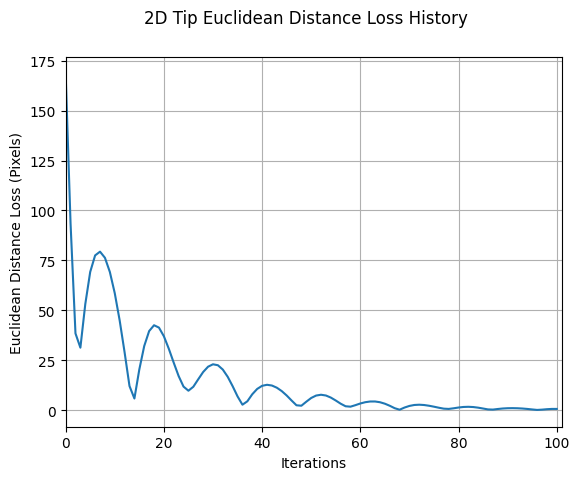

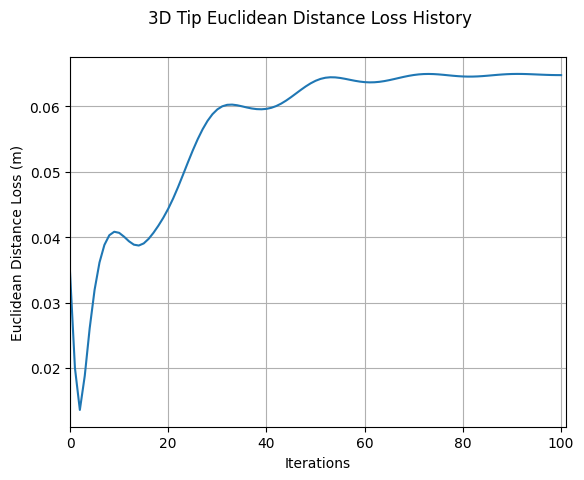

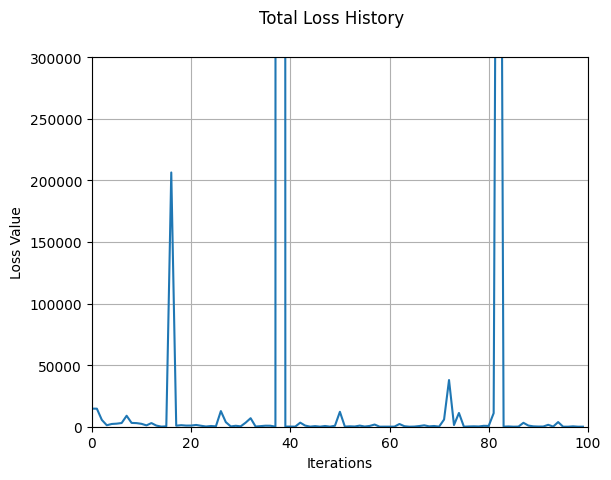

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:07,  1.29s/it, loss=4.89e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:09,  1.32s/it, loss=577]    


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:07,  1.31s/it, loss=3.78e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:06,  1.32s/it, loss=2.1e+3] 


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:09,  1.36s/it, loss=1.73e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:07,  1.36s/it, loss=1.21e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:09,  1.39s/it, loss=768]    


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:09,  1.40s/it, loss=7.54e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:04,  1.37s/it, loss=1.17e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:05,  1.40s/it, loss=552]   


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:15<02:02,  1.37s/it, loss=3.47e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<01:59,  1.36s/it, loss=690]    


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:58,  1.36s/it, loss=623]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:54,  1.33s/it, loss=3.79e+4]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:53,  1.34s/it, loss=1.68e+6]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:52,  1.34s/it, loss=2.54e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:23<01:53,  1.36s/it, loss=148]    


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:53,  1.38s/it, loss=369]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:50,  1.36s/it, loss=407]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:47,  1.35s/it, loss=2.87e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:46,  1.35s/it, loss=669]    


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:46,  1.36s/it, loss=613]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:45,  1.37s/it, loss=1.36e+5]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:42,  1.35s/it, loss=3.6e+3] 


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:40,  1.35s/it, loss=129]   


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:40,  1.36s/it, loss=8.57e+3]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:40,  1.38s/it, loss=377]    


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:37,  1.36s/it, loss=313]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:35,  1.35s/it, loss=262]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:34,  1.35s/it, loss=1.69e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:34,  1.37s/it, loss=92.9]   


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:32,  1.36s/it, loss=135] 


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:32,  1.38s/it, loss=160]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:31,  1.38s/it, loss=161]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:28,  1.37s/it, loss=142]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:31,  1.43s/it, loss=113]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:27,  1.39s/it, loss=371]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:25,  1.38s/it, loss=358]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:25,  1.40s/it, loss=87] 


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:21,  1.36s/it, loss=3.52e+4]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:21,  1.39s/it, loss=74.5]   


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:19,  1.37s/it, loss=1.07e+4]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:18,  1.38s/it, loss=80.2]   


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:16,  1.36s/it, loss=589] 


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:16,  1.38s/it, loss=2.72e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:15,  1.40s/it, loss=92]     


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:14,  1.40s/it, loss=82.6]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:10,  1.35s/it, loss=6.64e+3]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:09,  1.36s/it, loss=107]    


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:09,  1.38s/it, loss=1.66e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:08,  1.40s/it, loss=232]    


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:11<01:06,  1.39s/it, loss=85.5]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:05,  1.40s/it, loss=329] 


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:14<01:05,  1.43s/it, loss=1.36e+4]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:04,  1.44s/it, loss=122]    


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:17<01:03,  1.44s/it, loss=160]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:18<01:00,  1.41s/it, loss=545]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:59,  1.42s/it, loss=3.59e+4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:21<00:58,  1.42s/it, loss=17.5]   


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:22<00:55,  1.38s/it, loss=3.39e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:23<00:54,  1.40s/it, loss=1.38e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:25<00:55,  1.46s/it, loss=2.82e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:26<00:52,  1.42s/it, loss=805]    


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:28<00:51,  1.42s/it, loss=845]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:29<00:48,  1.38s/it, loss=3.31e+3]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:31<00:47,  1.39s/it, loss=39.2]   


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:32<00:45,  1.37s/it, loss=260] 


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:33<00:43,  1.37s/it, loss=57.2]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:35<00:42,  1.38s/it, loss=1.78e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:36<00:40,  1.36s/it, loss=40.6]   


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:37<00:40,  1.39s/it, loss=509] 


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:39<00:38,  1.37s/it, loss=79.6]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:40<00:36,  1.36s/it, loss=181] 


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:41<00:35,  1.38s/it, loss=1.08e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:43<00:33,  1.36s/it, loss=161]    


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:44<00:33,  1.38s/it, loss=478]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:46<00:31,  1.36s/it, loss=10.9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:47<00:29,  1.35s/it, loss=8.46e+5]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:48<00:28,  1.37s/it, loss=68.1]   


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:50<00:26,  1.35s/it, loss=458] 


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:51<00:25,  1.35s/it, loss=2.65e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:52<00:24,  1.35s/it, loss=108]    


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:54<00:22,  1.35s/it, loss=82.6]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:55<00:21,  1.34s/it, loss=128] 


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:56<00:20,  1.34s/it, loss=1.32e+3]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:58<00:18,  1.34s/it, loss=220]    


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:59<00:17,  1.34s/it, loss=713]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:00<00:16,  1.37s/it, loss=199]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:02<00:14,  1.35s/it, loss=3.13e+3]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:03<00:13,  1.38s/it, loss=2.45e+3]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:04<00:12,  1.37s/it, loss=36.1]   


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:06<00:10,  1.37s/it, loss=2.69e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:07<00:09,  1.37s/it, loss=46.9]   


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:09<00:08,  1.39s/it, loss=3.28e+5]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:10<00:06,  1.40s/it, loss=117]    


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:12<00:05,  1.46s/it, loss=571]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:13<00:04,  1.45s/it, loss=164]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:14<00:02,  1.42s/it, loss=88.6]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:16<00:01,  1.42s/it, loss=64.8]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:17<00:00,  1.38s/it, loss=76.1]


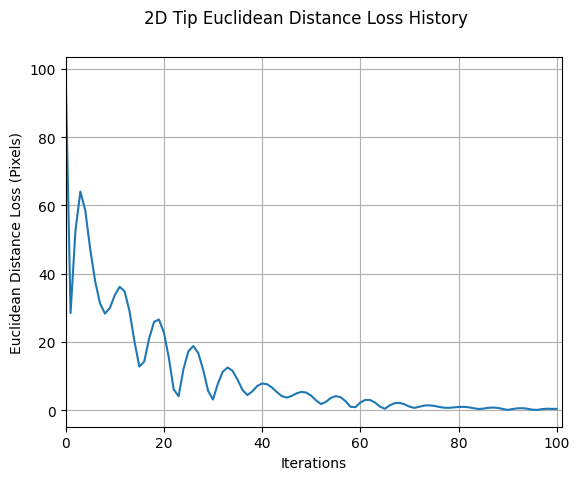

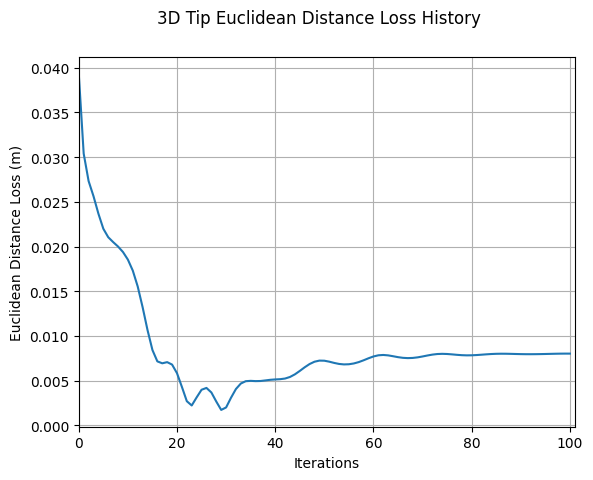

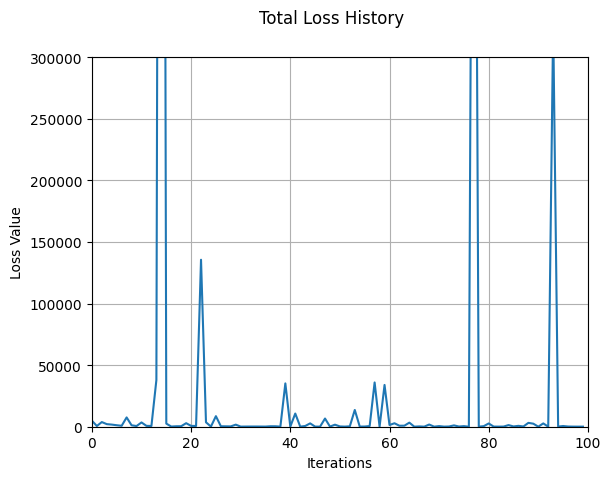

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:09,  1.31s/it, loss=1.48e+4]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:08,  1.32s/it, loss=4.75e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:06,  1.30s/it, loss=3.7e+3] 


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:05,  1.31s/it, loss=974]   


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:04,  1.31s/it, loss=2.1e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:03,  1.31s/it, loss=2.57e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:02,  1.32s/it, loss=3.12e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:05,  1.36s/it, loss=3.22e+4]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<02:02,  1.34s/it, loss=4.53e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:03,  1.37s/it, loss=2.24e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<02:01,  1.37s/it, loss=2.78e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<02:00,  1.37s/it, loss=6.11e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:57,  1.36s/it, loss=1.23e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:56,  1.35s/it, loss=691]    


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:56,  1.37s/it, loss=681]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:53,  1.35s/it, loss=630]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:51,  1.35s/it, loss=290]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:50,  1.35s/it, loss=459]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:51,  1.37s/it, loss=1.54e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:47,  1.35s/it, loss=815]    


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:45,  1.34s/it, loss=888]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:44,  1.34s/it, loss=861]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:30<01:44,  1.36s/it, loss=954]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:42,  1.35s/it, loss=493]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:43,  1.38s/it, loss=2.25e+4]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:41,  1.37s/it, loss=350]    


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:39,  1.36s/it, loss=1.39e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:39,  1.39s/it, loss=114]    


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:39,  1.39s/it, loss=410]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:38,  1.40s/it, loss=263]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:35,  1.38s/it, loss=379]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:34,  1.39s/it, loss=343]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:30,  1.35s/it, loss=879]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:29,  1.35s/it, loss=328]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:33,  1.44s/it, loss=898]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:30,  1.41s/it, loss=71] 


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:29,  1.41s/it, loss=197]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:26,  1.40s/it, loss=74.9]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:24,  1.38s/it, loss=405] 


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:23,  1.39s/it, loss=2.25e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:20,  1.36s/it, loss=154]    


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:20,  1.39s/it, loss=463]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:18,  1.37s/it, loss=173]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:16,  1.37s/it, loss=1.16e+3]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:17,  1.40s/it, loss=703]    


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:16,  1.41s/it, loss=120]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:13,  1.39s/it, loss=2.23e+3]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:14,  1.43s/it, loss=1.94e+3]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:07<01:11,  1.40s/it, loss=50.2]   


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:10,  1.42s/it, loss=59.2]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:08,  1.39s/it, loss=203] 


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:11<01:07,  1.40s/it, loss=1.99e+5]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:04,  1.38s/it, loss=163]    


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:14<01:04,  1.39s/it, loss=288]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:02,  1.38s/it, loss=72.2]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<01:01,  1.39s/it, loss=636] 


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:18<00:58,  1.36s/it, loss=103]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:58,  1.38s/it, loss=2.91e+3]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:21<00:56,  1.39s/it, loss=220]    


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:22<00:55,  1.39s/it, loss=423]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:23<00:54,  1.40s/it, loss=353]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:25<00:55,  1.47s/it, loss=334]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:26<00:53,  1.45s/it, loss=393]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:28<00:51,  1.43s/it, loss=284]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:29<00:49,  1.43s/it, loss=329]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:31<00:47,  1.40s/it, loss=133]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:32<00:46,  1.41s/it, loss=120]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:33<00:44,  1.39s/it, loss=314]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:35<00:43,  1.42s/it, loss=94.8]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:36<00:42,  1.43s/it, loss=190] 


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:38<00:40,  1.41s/it, loss=125]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:39<00:40,  1.43s/it, loss=257]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:41<00:38,  1.42s/it, loss=34] 


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:42<00:36,  1.40s/it, loss=114]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:43<00:35,  1.41s/it, loss=95.6]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:45<00:33,  1.38s/it, loss=1.45e+4]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:46<00:31,  1.37s/it, loss=30]     


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:47<00:30,  1.38s/it, loss=52.1]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:49<00:28,  1.38s/it, loss=1.07e+3]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:50<00:27,  1.36s/it, loss=7.98e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:51<00:26,  1.38s/it, loss=238]    


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:53<00:24,  1.36s/it, loss=96.6]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:54<00:23,  1.38s/it, loss=872] 


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:56<00:22,  1.39s/it, loss=127]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:57<00:21,  1.40s/it, loss=108]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:58<00:19,  1.38s/it, loss=107]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [02:00<00:18,  1.39s/it, loss=27.3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:01<00:16,  1.37s/it, loss=128] 


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:03<00:15,  1.38s/it, loss=53.4]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:04<00:13,  1.37s/it, loss=417] 


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:05<00:12,  1.37s/it, loss=497]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:07<00:11,  1.39s/it, loss=97.2]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:08<00:09,  1.40s/it, loss=553] 


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:09<00:08,  1.40s/it, loss=155]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:11<00:07,  1.50s/it, loss=38.7]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:13<00:05,  1.44s/it, loss=129] 


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:14<00:04,  1.43s/it, loss=23.9]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:15<00:02,  1.43s/it, loss=2.11e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:17<00:01,  1.41s/it, loss=143]    


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it, loss=61.9]


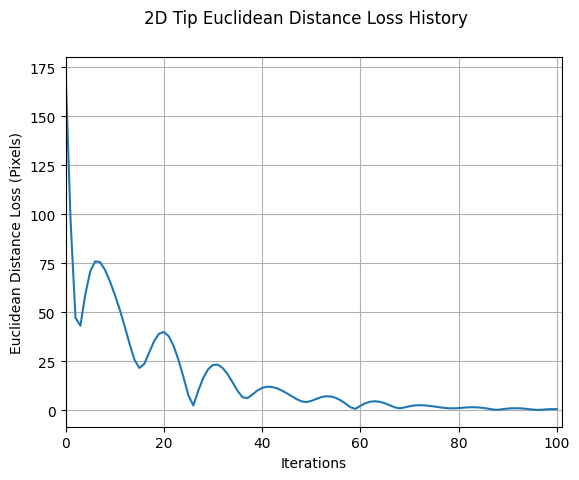

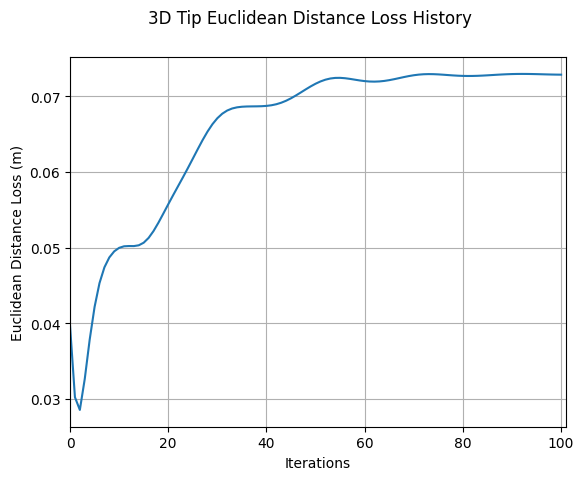

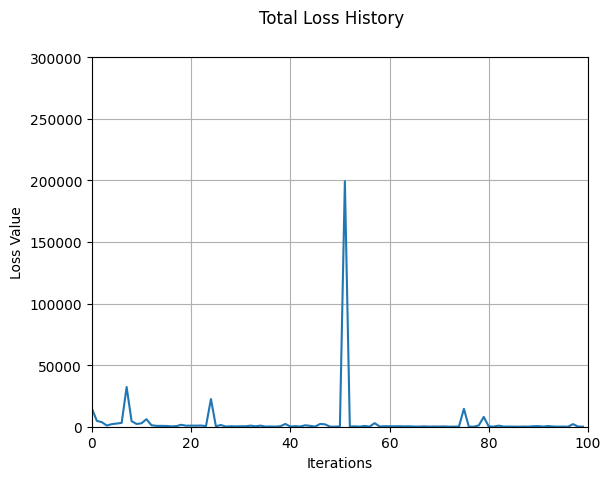

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:04,  1.26s/it, loss=2e+4]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:06,  1.29s/it, loss=6.9e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:06,  1.31s/it, loss=1.06e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:07,  1.33s/it, loss=462]    


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:06,  1.33s/it, loss=1.52e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:05,  1.33s/it, loss=3.45e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:03,  1.33s/it, loss=4.53e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:03,  1.34s/it, loss=4.63e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:03,  1.36s/it, loss=6.68e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:00,  1.34s/it, loss=3.15e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<02:02,  1.37s/it, loss=2.25e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<01:58,  1.35s/it, loss=1.21e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:58,  1.36s/it, loss=590]    


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:58,  1.38s/it, loss=1.61e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:55,  1.36s/it, loss=7.83e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:53,  1.35s/it, loss=1.38e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:52,  1.35s/it, loss=1.82e+4]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:52,  1.37s/it, loss=5.92e+4]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:49,  1.35s/it, loss=6.1e+3] 


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:48,  1.36s/it, loss=7.75e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:48,  1.37s/it, loss=1.04e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:46,  1.36s/it, loss=755]    


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:45,  1.38s/it, loss=1.11e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:43,  1.36s/it, loss=1.82e+3]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:42,  1.37s/it, loss=8.74e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:40,  1.36s/it, loss=98.8]   


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:40,  1.37s/it, loss=113] 


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:38,  1.37s/it, loss=1.2e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:34,  1.33s/it, loss=272]   


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:33,  1.34s/it, loss=3.25e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:41<01:33,  1.36s/it, loss=293]    


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:32,  1.36s/it, loss=2.35e+3]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:32,  1.38s/it, loss=434]    


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:31,  1.39s/it, loss=264]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:29,  1.37s/it, loss=414]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:31,  1.44s/it, loss=496]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:28,  1.41s/it, loss=163]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:28,  1.43s/it, loss=557]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:27,  1.43s/it, loss=85.4]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:26,  1.44s/it, loss=115] 


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:56<01:23,  1.41s/it, loss=111]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:20,  1.39s/it, loss=654]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:19,  1.40s/it, loss=299]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:17,  1.38s/it, loss=314]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:16,  1.39s/it, loss=324]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:14,  1.37s/it, loss=1.25e+4]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:12,  1.37s/it, loss=1.99e+3]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:12,  1.40s/it, loss=185]    


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:07<01:09,  1.37s/it, loss=68.5]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:08<01:08,  1.38s/it, loss=516] 


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:06,  1.36s/it, loss=553]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:11<01:06,  1.39s/it, loss=122]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:04,  1.37s/it, loss=49.9]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:14<01:04,  1.40s/it, loss=413] 


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:15<01:03,  1.41s/it, loss=125]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<01:01,  1.40s/it, loss=2.94e+3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:18<00:59,  1.39s/it, loss=582]    


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:19<00:57,  1.37s/it, loss=212]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:57,  1.39s/it, loss=51] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:22<00:55,  1.38s/it, loss=2.59e+5]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:23<00:54,  1.41s/it, loss=551]    


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:25<00:51,  1.36s/it, loss=166]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:26<00:54,  1.47s/it, loss=51.9]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:28<00:51,  1.42s/it, loss=1.5e+4]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:29<00:50,  1.44s/it, loss=53.9]  


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:30<00:47,  1.41s/it, loss=655] 


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:32<00:45,  1.39s/it, loss=555]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:33<00:44,  1.40s/it, loss=71.7]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:34<00:42,  1.37s/it, loss=18.7]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:36<00:41,  1.37s/it, loss=211] 


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:37<00:40,  1.39s/it, loss=3.16e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:39<00:38,  1.39s/it, loss=304]    


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:40<00:36,  1.37s/it, loss=4.03e+3]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:41<00:34,  1.34s/it, loss=1.43e+4]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:43<00:33,  1.36s/it, loss=1.43e+3]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:44<00:33,  1.38s/it, loss=102]    


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:45<00:31,  1.37s/it, loss=183]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:47<00:30,  1.38s/it, loss=302]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:48<00:28,  1.37s/it, loss=42.7]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:50<00:27,  1.38s/it, loss=27.3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:51<00:26,  1.38s/it, loss=9.75e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:52<00:24,  1.37s/it, loss=117]    


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:54<00:23,  1.39s/it, loss=3.42e+4]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:55<00:22,  1.39s/it, loss=45.2]   


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:57<00:21,  1.41s/it, loss=59.1]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:58<00:19,  1.41s/it, loss=170] 


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:59<00:18,  1.39s/it, loss=445]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:01<00:16,  1.42s/it, loss=114]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:02<00:15,  1.39s/it, loss=806]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:04<00:14,  1.40s/it, loss=3.98e+3]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:05<00:12,  1.37s/it, loss=331]    


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:06<00:10,  1.36s/it, loss=5.42e+8]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:08<00:09,  1.38s/it, loss=147]    


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:09<00:08,  1.36s/it, loss=146]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:10<00:06,  1.37s/it, loss=32.3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:12<00:05,  1.45s/it, loss=272] 


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:13<00:04,  1.42s/it, loss=596]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:15<00:02,  1.42s/it, loss=142]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:16<00:01,  1.39s/it, loss=98.8]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:18<00:00,  1.38s/it, loss=54.1]


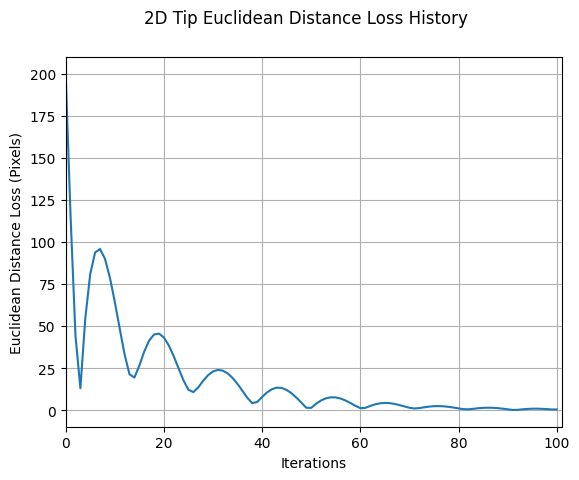

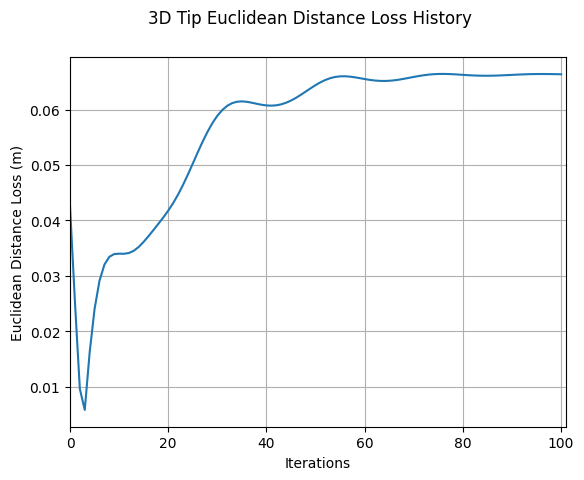

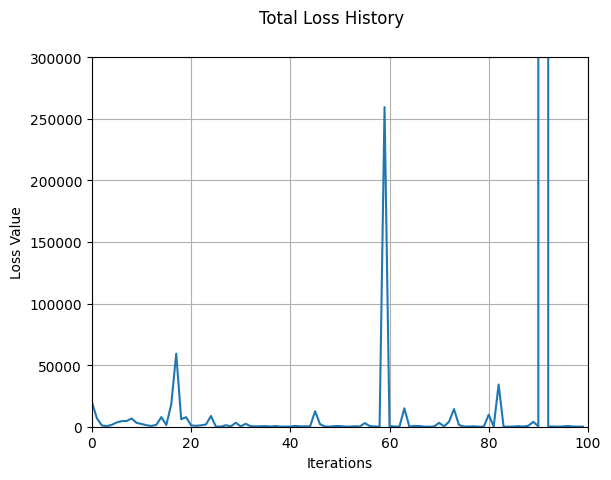

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:14,  1.36s/it, loss=2.29e+4]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:12,  1.35s/it, loss=1.35e+4]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:04<02:09,  1.33s/it, loss=4.73e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:07,  1.32s/it, loss=2.96e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:06,  1.33s/it, loss=2.24e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:06,  1.34s/it, loss=2.38e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:06,  1.36s/it, loss=3.54e+5]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:03,  1.34s/it, loss=3.33e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:04,  1.36s/it, loss=2.57e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:01,  1.35s/it, loss=2.34e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<02:02,  1.38s/it, loss=2.24e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<02:02,  1.39s/it, loss=2.03e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:59,  1.37s/it, loss=4.78e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:19<01:58,  1.37s/it, loss=1.55e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:58,  1.39s/it, loss=822]    


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:57,  1.40s/it, loss=340]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:23<01:51,  1.35s/it, loss=203]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:50,  1.35s/it, loss=470]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:51,  1.38s/it, loss=484]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:49,  1.37s/it, loss=3.08e+4]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:48,  1.37s/it, loss=1.63e+4]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:30<01:47,  1.37s/it, loss=744]    


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:47,  1.40s/it, loss=1.96e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:44,  1.37s/it, loss=927]    


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:45,  1.41s/it, loss=970]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:35<01:42,  1.38s/it, loss=318]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:41,  1.39s/it, loss=171]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:38,  1.37s/it, loss=678]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:39<01:39,  1.40s/it, loss=59.1]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:41<01:37,  1.39s/it, loss=1.49e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:36,  1.40s/it, loss=132]    


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:44<01:36,  1.43s/it, loss=253]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:45<01:34,  1.41s/it, loss=413]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:31,  1.39s/it, loss=265]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:48<01:31,  1.41s/it, loss=700]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:29,  1.40s/it, loss=242]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:51<01:29,  1.42s/it, loss=328]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:52<01:27,  1.40s/it, loss=221]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:24,  1.39s/it, loss=109]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:55<01:25,  1.43s/it, loss=254]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:56<01:22,  1.39s/it, loss=881]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:58<01:21,  1.41s/it, loss=82.9]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:59<01:19,  1.40s/it, loss=711] 


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:00<01:18,  1.40s/it, loss=371]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:02<01:16,  1.39s/it, loss=83.2]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:03<01:16,  1.41s/it, loss=41.8]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:05<01:14,  1.40s/it, loss=158] 


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:06<01:12,  1.39s/it, loss=354]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:07<01:10,  1.38s/it, loss=78.2]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:09<01:09,  1.40s/it, loss=155] 


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:10<01:07,  1.38s/it, loss=92.1]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:11<01:07,  1.40s/it, loss=2.53e+4]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:13<01:03,  1.36s/it, loss=2.24e+4]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:14<01:04,  1.39s/it, loss=123]    


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:16<01:03,  1.41s/it, loss=388]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:17<01:01,  1.39s/it, loss=62.3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:18<01:00,  1.41s/it, loss=1.2e+3]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:20<00:58,  1.39s/it, loss=81.9]  


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:21<00:57,  1.40s/it, loss=163] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:23<00:55,  1.38s/it, loss=474]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:24<00:54,  1.41s/it, loss=87.7]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:25<00:52,  1.39s/it, loss=39.6]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:27<00:54,  1.47s/it, loss=148] 


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:28<00:51,  1.44s/it, loss=232]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:30<00:50,  1.43s/it, loss=788]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:31<00:47,  1.40s/it, loss=906]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:33<00:46,  1.42s/it, loss=145]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:34<00:44,  1.39s/it, loss=102]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:35<00:43,  1.39s/it, loss=19.3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:37<00:41,  1.38s/it, loss=2.94e+3]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:38<00:39,  1.38s/it, loss=563]    


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:39<00:39,  1.39s/it, loss=140]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:41<00:37,  1.38s/it, loss=99.2]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:42<00:35,  1.37s/it, loss=275] 


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:44<00:34,  1.37s/it, loss=2.38e+6]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:45<00:32,  1.37s/it, loss=38.9]   


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:46<00:31,  1.38s/it, loss=59.1]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:48<00:30,  1.41s/it, loss=333] 


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:49<00:29,  1.43s/it, loss=141]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:51<00:28,  1.42s/it, loss=130]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:52<00:26,  1.41s/it, loss=2.51e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:53<00:25,  1.42s/it, loss=388]    


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:55<00:23,  1.39s/it, loss=523]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:56<00:22,  1.40s/it, loss=7.65e+4]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:58<00:21,  1.40s/it, loss=1.68e+4]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:59<00:19,  1.39s/it, loss=270]    


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [02:00<00:17,  1.37s/it, loss=53.7]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [02:02<00:16,  1.36s/it, loss=304] 


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [02:03<00:15,  1.37s/it, loss=200]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:04<00:13,  1.39s/it, loss=559]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:06<00:12,  1.37s/it, loss=775]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:07<00:10,  1.36s/it, loss=2.1e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:09<00:09,  1.39s/it, loss=920]   


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:10<00:08,  1.37s/it, loss=24.8]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:11<00:06,  1.38s/it, loss=265] 


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:13<00:05,  1.37s/it, loss=309]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:14<00:04,  1.46s/it, loss=270]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:16<00:02,  1.43s/it, loss=126]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:17<00:01,  1.43s/it, loss=9.52e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it, loss=533]   


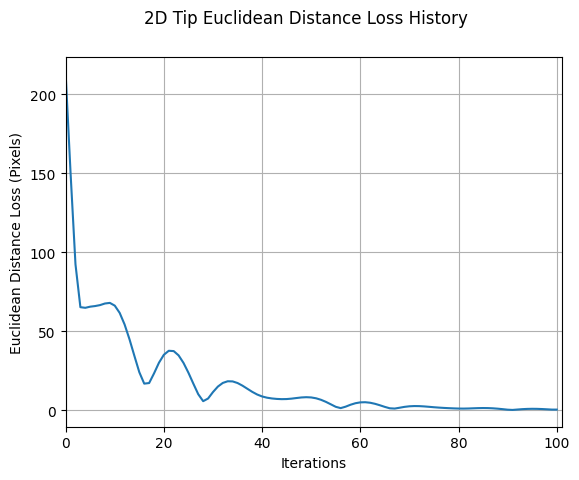

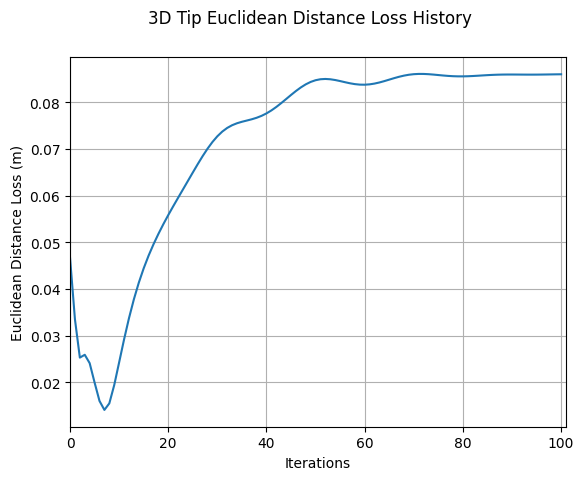

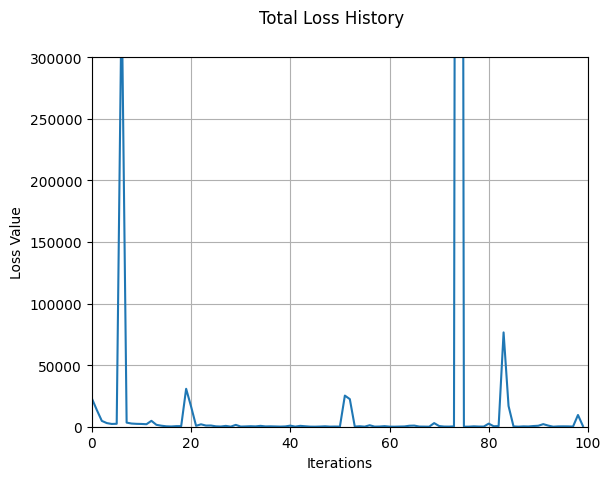

In [54]:
para_init_0 = np.array([0.0365, 0.0036, 0.1202, 0.0056, -0.0166, 0.1645], dtype=np.float32)
para_init_1 = np.array([0.03, 0.0055, 0.0702, 0.0206, -0.0306, 0.1845], dtype=np.float32)
para_init_3 = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0306, 0.1815], dtype=np.float32)
para_init_list = [para_init_0, para_init_1, para_init_3] + vectors
print(len(para_init_list))

for i, para_init in enumerate(para_init_list):
    excecute(para_init, i+1)